In [1]:
import awkward as ak
import numba as nb
import numpy as np
import uproot
import awkward

import os
import sys

# For a timer function
import contextlib
import time
from time import gmtime, strftime
from tqdm import tqdm

# For getting file paths
import socket

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
import mplhep

from hyper import hyper_obj
from hyper import hyper_dual_obj
from hyper import hyper_tri_obj

# For histogram generation
import boost_histogram as bh
from copy import deepcopy
import pickle

from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

#from catalog_client import Catalog, FatalError

%config InlineBackend.figure_format = 'retina'

In [2]:
def read_run_paths(runs:list, filetype:str):
    #Q: What is catalog_client and how does it operate to find these paths?
    from catalog_client import Catalog, FatalError
    options = ['raw','rq']
    
    if filetype not in options:
        print("please select filetype 'raw' or 'rq'")
        return 0
    print('Finding files from %i runs...'%len(runs))
    DATA_DC = 'usdc'
    #setup catalog
    #Q: What do these lines do?
    CATALOG_APPLICATION = "https://lz-catalog.lbl.gov/catalog/{}/report/".format(DATA_DC)
    CATALOG_DEBUG = 0
    cat = Catalog(CATALOG_APPLICATION, 'url',  xml=('1'==CATALOG_DEBUG), triggers = ['canonical_path'])
    
    #create request: raw files for this project
    sel = cat.select('run',runs)
    sel += cat.select('type', filetype)
    
    #return requestd
    paths = list(sel)
    return paths

In [3]:
#Href files: 10797-10801, 10803-10808
#dd_files = read_run_paths([10798, 10799, 10800, 10801, 10803, 10804, 10805, 10806, 10807, 10808],'rq')
#dd_files = read_run_paths([10798, 10799, 10800, 10801],'rq')
#dd_files = read_run_paths([10798, 10799, 10800, 10801, 10803, 10804, 10805],'rq')
#dd_files = read_run_paths([10801, 10803, 10804, 10805],'rq')
#dd_files = read_run_paths([10803, 10804, 10805, 10806, 10807, 10808], 'rq')
dd_files = read_run_paths([10798], 'rq')

#Dref files 10751-10757, 10776, 10787, 10789-10792
#dd_files = read_run_paths([10751, 10752, 10753, 10754], 'rq')

#Pre-SR1 DD-direct files: 6101-6109
#dd_files = read_run_paths([6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109], 'rq')
#dd_files = read_run_paths([6101], 'rq')

#Pre-SR1 Href files: 6239-6254, 6256-6260
#dd_files = read_run_paths([6254], 'rq')

#Pre-SR2 DD-direct files: 10817-10830
#dd_files = read_run_paths([10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825], 'rq')



#Href CS-131 test: 10715, with Cs source 60cm away from Href
#dd_files = read_run_paths([10715], 'rq')

dd_files_new = []
#for i in range(len(dd_files)):
    #print(dd_files[i])
for i in range(len(dd_files)):
    #print(dd_files[i][63:71])
    if (dd_files[i][56:64]=='9_PROD-1'):
    #if (dd_files[i][63:71]=='8_PROD-0'):
        dd_files_new.append(dd_files[i])

dd_files = dd_files_new
#for i in range(len(dd_files)):
    #print(dd_files[i])
print(len(dd_files))

Finding files from 1 runs...
800


In [48]:
#Go back to basics. First, develop understanding of drift times
xy_hist = bh.Histogram(bh.axis.Regular(200, -80, 80),bh.axis.Regular(200, -80, 80))
s1s2_hist = bh.Histogram(bh.axis.Regular(200, 0, 5),bh.axis.Regular(200, 1, 7))
#s1s2_hist = bh.Histogram(bh.axis.Regular(50, 1.6, 2.0),bh.axis.Regular(50, 3.6, 4))
#s1s2_hist = bh.Histogram(bh.axis.Regular(50, 40, 160),bh.axis.Regular(50, 3.6, 4))
s1s2_hist_rcut = bh.Histogram(bh.axis.Regular(200, 0, 5),bh.axis.Regular(200, 1, 7))
s1s2_hist_rcut_zcut = bh.Histogram(bh.axis.Regular(200, 0, 5),bh.axis.Regular(200, 1, 7))
s1s2_hist_rcut_ycut_zcut = bh.Histogram(bh.axis.Regular(200, 0, 5),bh.axis.Regular(200, 1, 7))
s1s2_hist_nrcut = bh.Histogram(bh.axis.Regular(200, 0, 5),bh.axis.Regular(200, 1, 7))
rz_hist = bh.Histogram(bh.axis.Regular(200, 0, 80),bh.axis.Regular(200, 200, 0))
xz_hist = bh.Histogram(bh.axis.Regular(200, 0, 80),bh.axis.Regular(200, 200, 0))

rpos_array = []
drift_time_array = []

rpos_lim = 69.5
rpos_lim_lower = 0
drift_time_lim = [10,120]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 15
b_lb = -15

#Parameters for isolating NR band with diagonal lines
a1 = 0.5
#a2 = 0.6
#a2 = 0.77
#a2 = 1.2
#s2 > 2.6
a2 = 1.02
c1 = 6.2
#c2 = 4.1
#c2 = 2.73
#c2 = 1
#s2 > 2.6
c2 = 1.55


inside_nocut = 0
total_nocut = 0
inside_rcut = 0
total_rcut = 0
inside_rcut_zcut = 0
total_rcut_zcut = 0
inside_rcut_ycut_zcut = 0
total_rcut_ycut_zcut = 0

for i in range(len(dd_files)):
    if (i == 0):
        continue
    file = uproot.open(dd_files[i])
    ss_cut = (file['Scatters;1']['ss./ss.nSingleScatters']==1)
    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    s1_corrected_area = file['Scatters']['ss./ss.correctedS1Area_phd'].array(library='np')
    s2_corrected_area = file['Scatters']['ss./ss.correctedS2Area_phd'].array(library='np')
    
    logs1c = np.log10(s1_corrected_area)
    logs2c = np.log10(s2_corrected_area)
    
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000
    
    rpos = np.sqrt(xpos**2 + ypos**2)

    rpos_cut = (rpos < rpos_lim) & (rpos > rpos_lim_lower) & (xpos < 0)
    #y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    y_cut = (ypos < 15) & (ypos > -15)
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])
    
    s1_area_cut = (s1_corrected_area > 2) & (s1_corrected_area < 125)
    #s2_area_cut = (np.log10(s2_corrected_area) > 2.8) & (np.log10(s2_corrected_area) < 4)
    s2_area_cut = (np.log10(s2_corrected_area) > 2.6) & (np.log10(s2_corrected_area) < 4)
    #s2_area_cut = (np.log10(s2_corrected_area) > 2)
    #s1_area_cut = (logs1c > 2.2) & (logs1c < 2.5)
    #s2_area_cut = (logs2c > 4.3) & (logs2c < 4.65)
    
    nr_cut = (logs2c/a1 - logs1c < c1) & (logs2c/a2 - logs1c > c2)
    
    xy_hist.fill(xpos, ypos)
    s1s2_hist.fill(logs1c, logs2c)
    s1s2_hist_rcut.fill(logs1c[rpos_cut], logs2c[rpos_cut])
    s1s2_hist_rcut_zcut.fill(logs1c[rpos_cut&z_cut], logs2c[rpos_cut&z_cut])
    s1s2_hist_rcut_ycut_zcut.fill(logs1c[rpos_cut&y_cut&z_cut], logs2c[rpos_cut&y_cut&z_cut])
    #s1s2_hist_nrcut.fill(logs1c[nr_cut&s1_area_cut&s2_area_cut], logs2c[nr_cut&s1_area_cut&s2_area_cut])
    s1s2_hist_nrcut.fill(logs1c[nr_cut&s1_area_cut&s2_area_cut], logs2c[nr_cut&s1_area_cut&s2_area_cut])
    
    
    inside_nocut += len(logs1c[nr_cut&s1_area_cut&s2_area_cut])
    total_nocut += len(logs1c)
    inside_rcut += len(logs1c[nr_cut&s1_area_cut&s2_area_cut&rpos_cut])
    total_rcut += len(logs1c[rpos_cut])
    inside_rcut_zcut += len(logs1c[nr_cut&s1_area_cut&s2_area_cut&rpos_cut&z_cut])
    total_rcut_zcut += len(logs1c[rpos_cut&z_cut])
    inside_rcut_ycut_zcut += len(logs1c[nr_cut&s1_area_cut&s2_area_cut&rpos_cut&y_cut&z_cut])
    total_rcut_ycut_zcut += len(logs1c[rpos_cut&y_cut&z_cut])
    
    #s1s2_hist.fill(s1_corrected_area, logs2c)
    rz_hist.fill(rpos, drift_time_us)
    xz_hist.fill(xpos[y_cut&s2_area_cut], drift_time_us[y_cut&s2_area_cut])
    for j in range(len(drift_time_us[y_cut&s2_area_cut])):
        drift_time_array.append(drift_time_us[j])
    for j in range(len(drift_time_us)):
        rpos_array.append(rpos[j])
        
    if ((i % 50) == 0):
        print("Done with file ", i)
    #print(xpos)
    #print(ypos)


/tmp/ipykernel_34645/4192562508.py:59: RuntimeWarning: invalid value encountered in log10
  logs1c = np.log10(s1_corrected_area)
/tmp/ipykernel_34645/4192562508.py:60: RuntimeWarning: invalid value encountered in log10
  logs2c = np.log10(s2_corrected_area)
/tmp/ipykernel_34645/4192562508.py:73: RuntimeWarning: invalid value encountered in log10
  s2_area_cut = (np.log10(s2_corrected_area) > 2.6) & (np.log10(s2_corrected_area) < 4)
/tmp/ipykernel_34645/4192562508.py:64: RuntimeWarning: overflow encountered in square
  rpos = np.sqrt(xpos**2 + ypos**2)


Done with file  50
Done with file  100
Done with file  150
Done with file  200
Done with file  250
Done with file  300
Done with file  350
Done with file  400
Done with file  450
Done with file  500
Done with file  550
Done with file  600
Done with file  650
Done with file  700
Done with file  750
Done with file  800
Done with file  850
Done with file  900
Done with file  950
Done with file  1000
Done with file  1050
Done with file  1100
Done with file  1150
Done with file  1200
Done with file  1250
Done with file  1300
Done with file  1350
Done with file  1400
Done with file  1450
Done with file  1500
Done with file  1550
Done with file  1600
Done with file  1650
Done with file  1700
Done with file  1750
Done with file  1800
Done with file  1850
Done with file  1900
Done with file  1950
Done with file  2000
Done with file  2050
Done with file  2100
Done with file  2150
Done with file  2200
Done with file  2250
Done with file  2300
Done with file  2350
Done with file  2400
Done with fi

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f30de6895e0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f30efc0e700>, text=[])

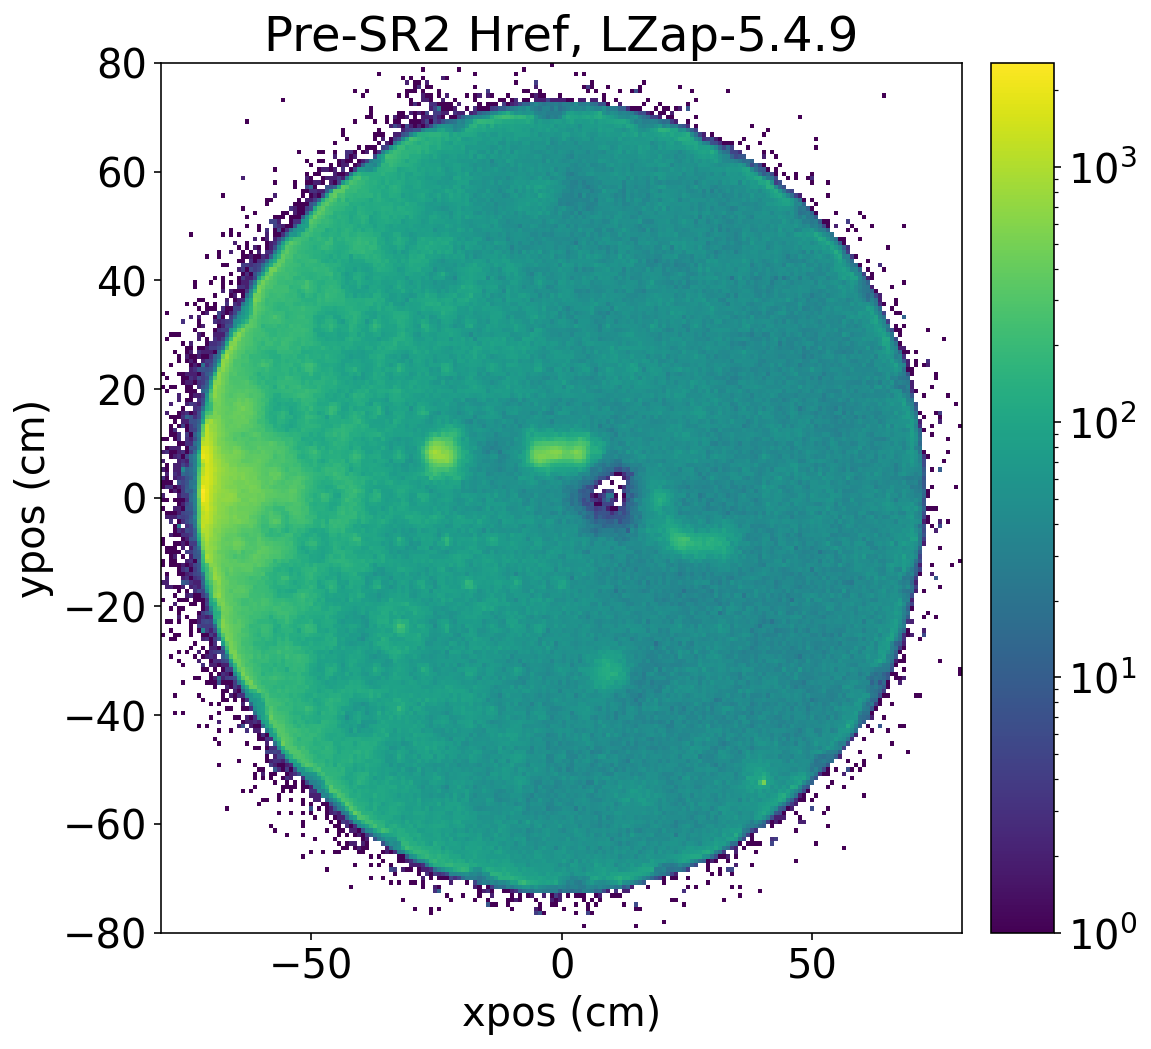

In [7]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(8, 8))
plt.xlabel('xpos (cm)')
plt.ylabel('ypos (cm)')
plt.title('Pre-SR2 Href, LZap-5.4.9') 
mplhep.hist2dplot(xy_hist, norm=LogNorm())

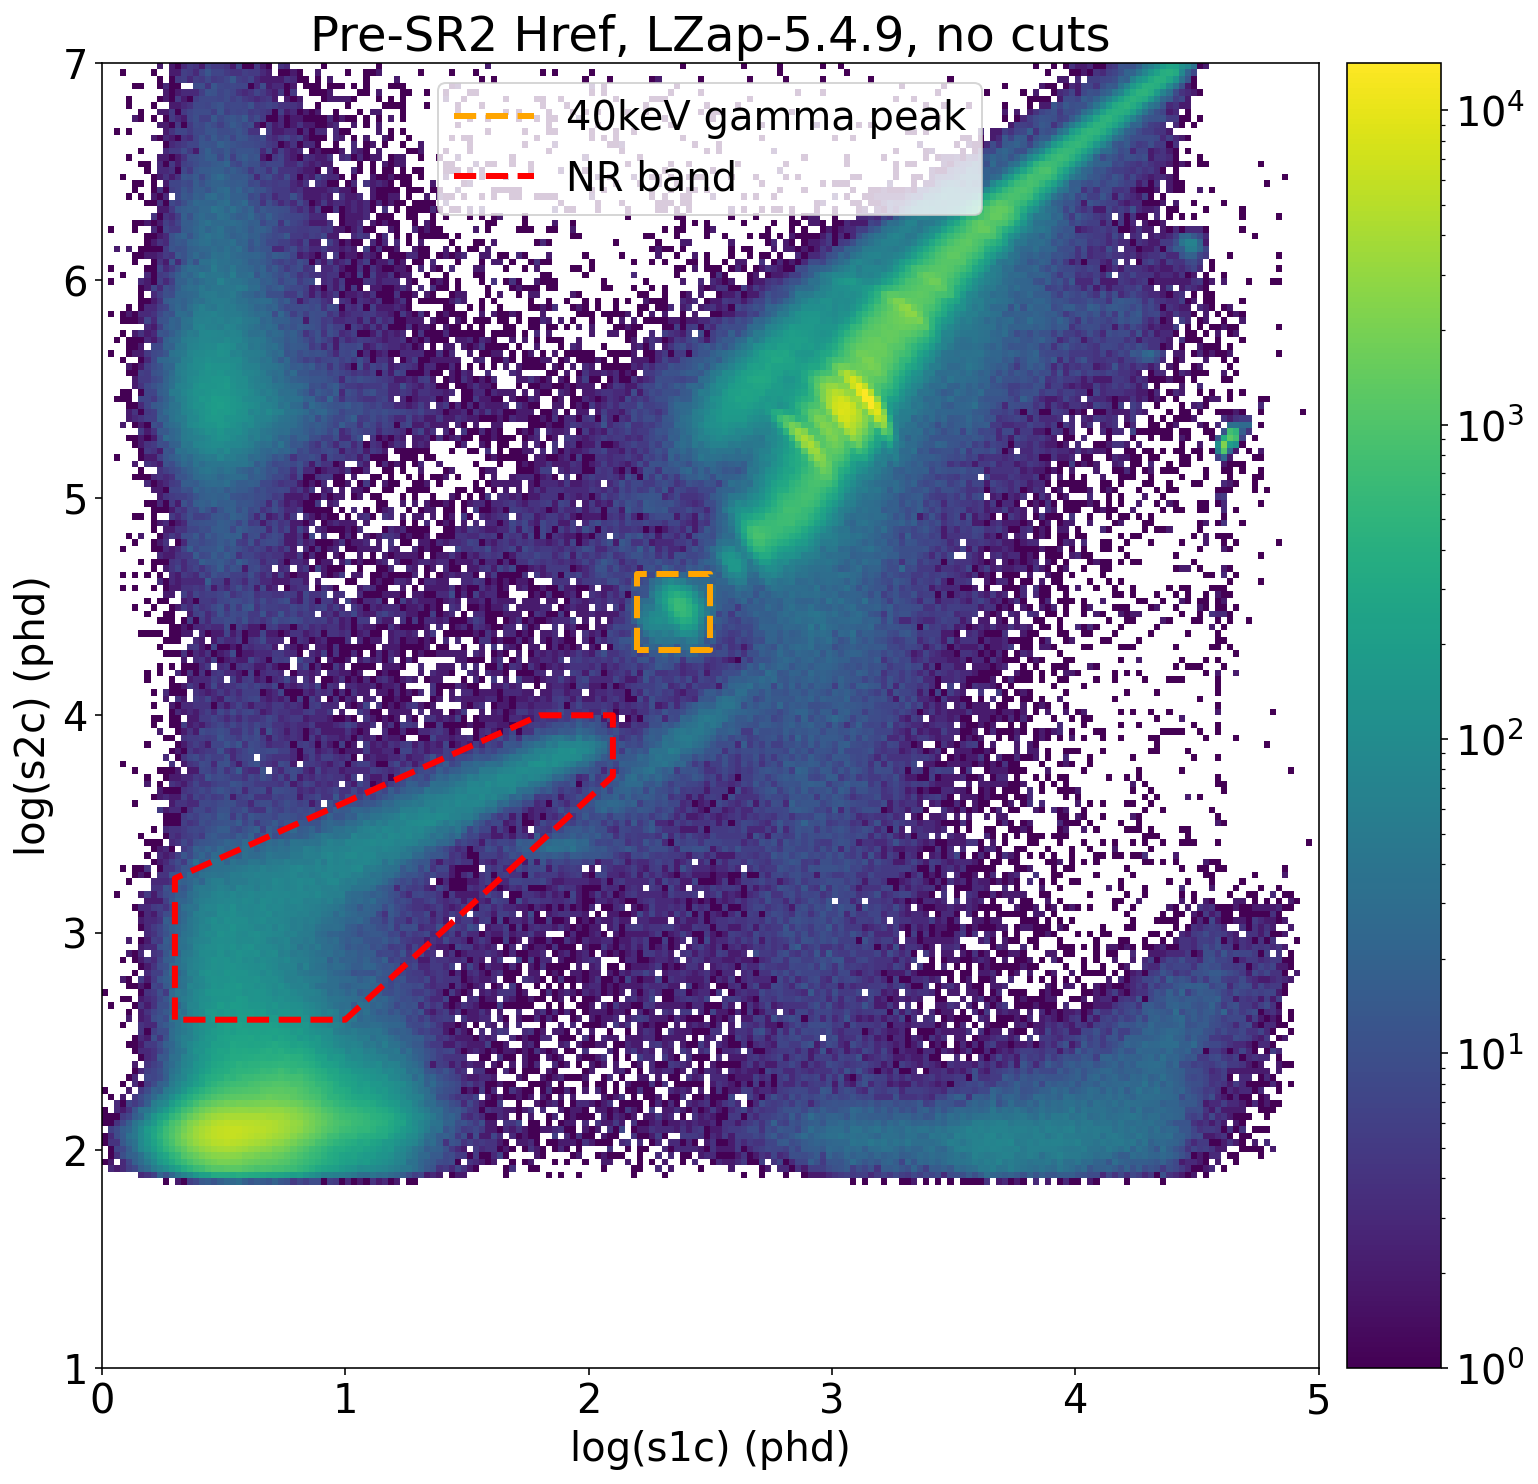

Events inside S1, S2 thresholds:  84135
Total events:  8507750


In [50]:
plt.rcParams.update({'font.size': 20})
x_p = [2.2,2.2,2.5,2.5]
y_p = [4.3,4.65,4.65,4.3]
x_p = np.append(x_p, x_p[0])
y_p = np.append(y_p, y_p[0])

#x2_p = [0.3,0.3,1.8,2.1,2.1,0.567]
#y2_p = [2.8,3.25,4,4,3.72, 2.8]
x2_p = [0.3,0.3,1.8,2.1,2.1,1]
y2_p = [2.6,3.25,4,4,3.72, 2.6]
x2_p = np.append(x2_p, x2_p[0])
y2_p = np.append(y2_p, y2_p[0])

fig = plt.figure(figsize=(12, 12))
plt.xlabel('log(s1c) (phd)')
plt.ylabel('log(s2c) (phd)')
plt.title('Pre-SR2 Href, LZap-5.4.9, no cuts') 
mplhep.hist2dplot(s1s2_hist, norm=LogNorm())
plt.plot(x_p,y_p,color='orange', linestyle='dashed', lw=3, label='40keV gamma peak')
plt.plot(x2_p,y2_p,color='red',linestyle='dashed', lw=3, label='NR band')
plt.legend(loc='upper center')
plt.show()

print("Events inside S1, S2 thresholds: ", inside_nocut)
print("Total events: ", total_nocut)

Events inside S1, S2 thresholds:  19752
Total events:  528203


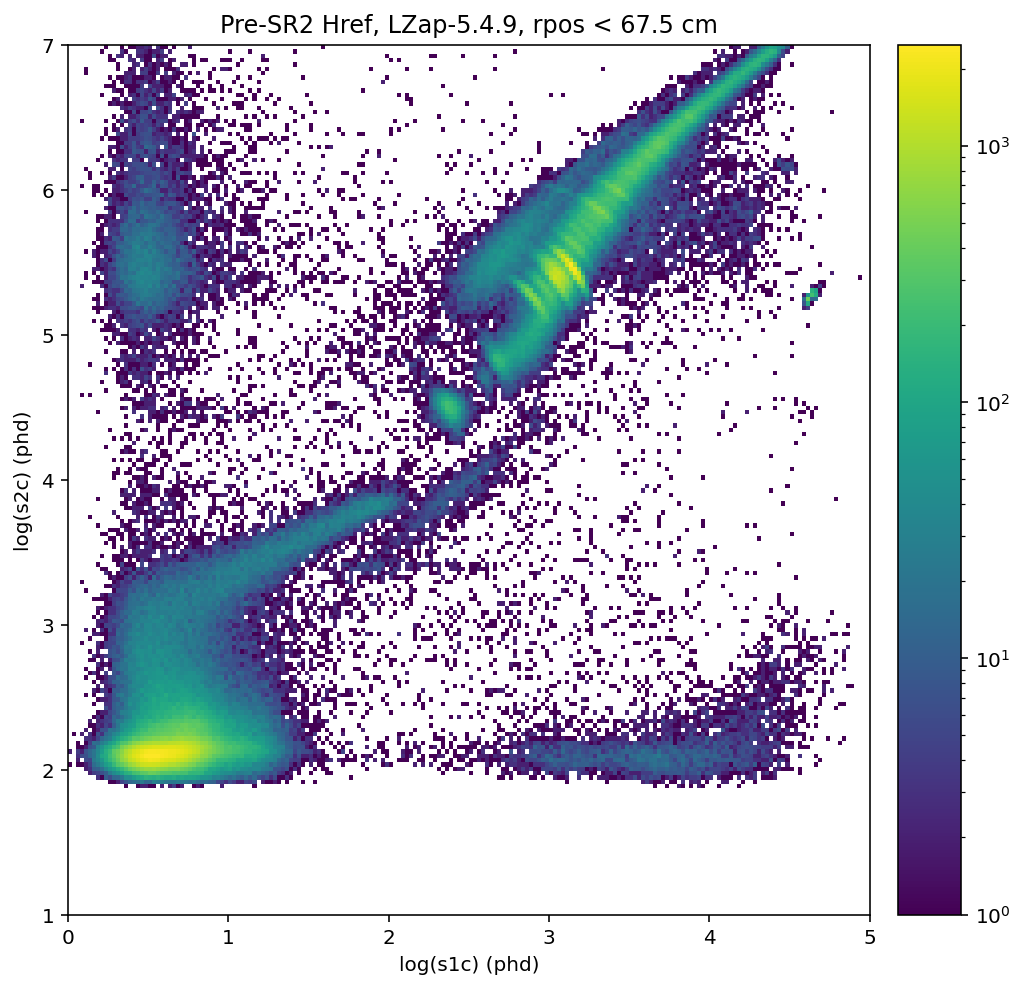

In [105]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('log(s1c) (phd)')
plt.ylabel('log(s2c) (phd)')
plt.title('Pre-SR2 Href, LZap-5.4.9, rpos < 67.5 cm') 
mplhep.hist2dplot(s1s2_hist_rcut, norm=LogNorm())

print("Events inside S1, S2 thresholds: ", inside_rcut)
print("Total events: ", total_rcut)

Events inside S1, S2 thresholds:  12983
Total events:  118251


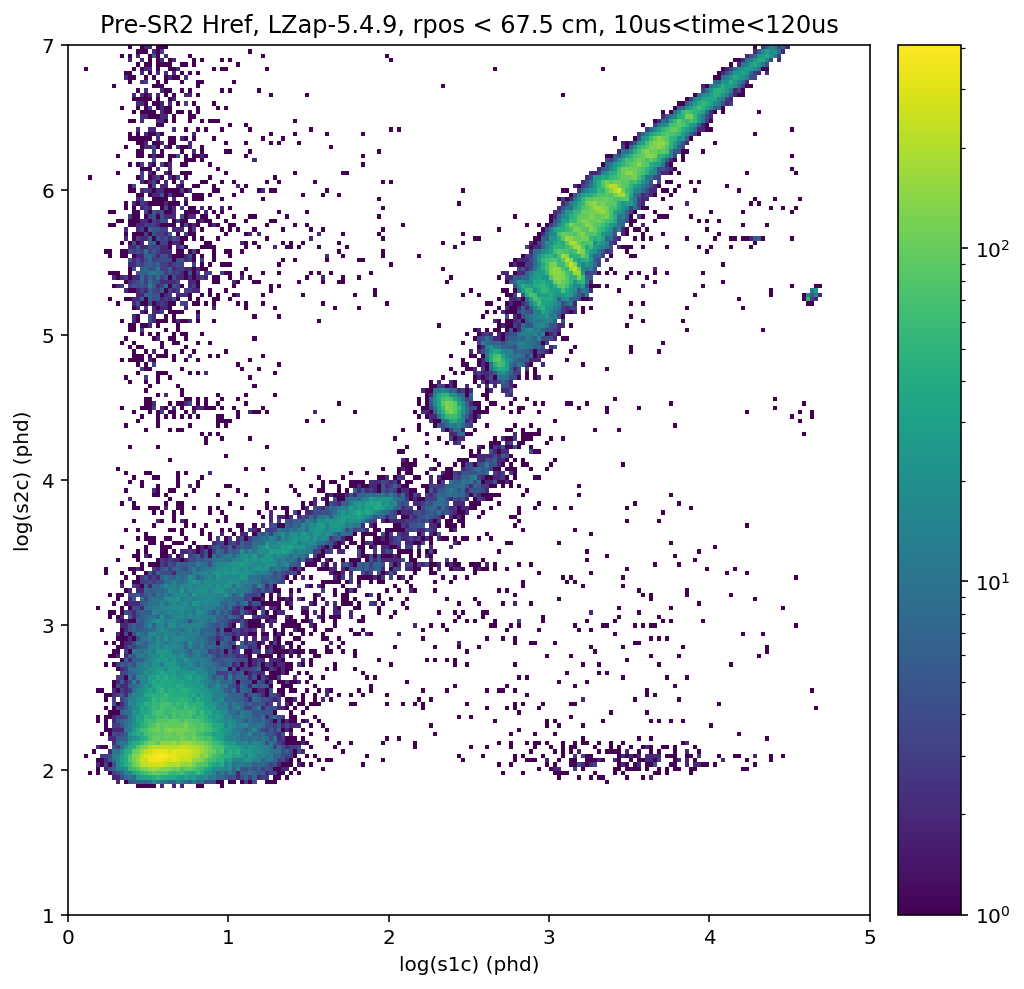

In [106]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('log(s1c) (phd)')
plt.ylabel('log(s2c) (phd)')
plt.title('Pre-SR2 Href, LZap-5.4.9, rpos < 67.5 cm, 10us<time<120us') 
mplhep.hist2dplot(s1s2_hist_rcut_zcut, norm=LogNorm())

print("Events inside S1, S2 thresholds: ", inside_rcut_zcut)
print("Total events: ", total_rcut_zcut)

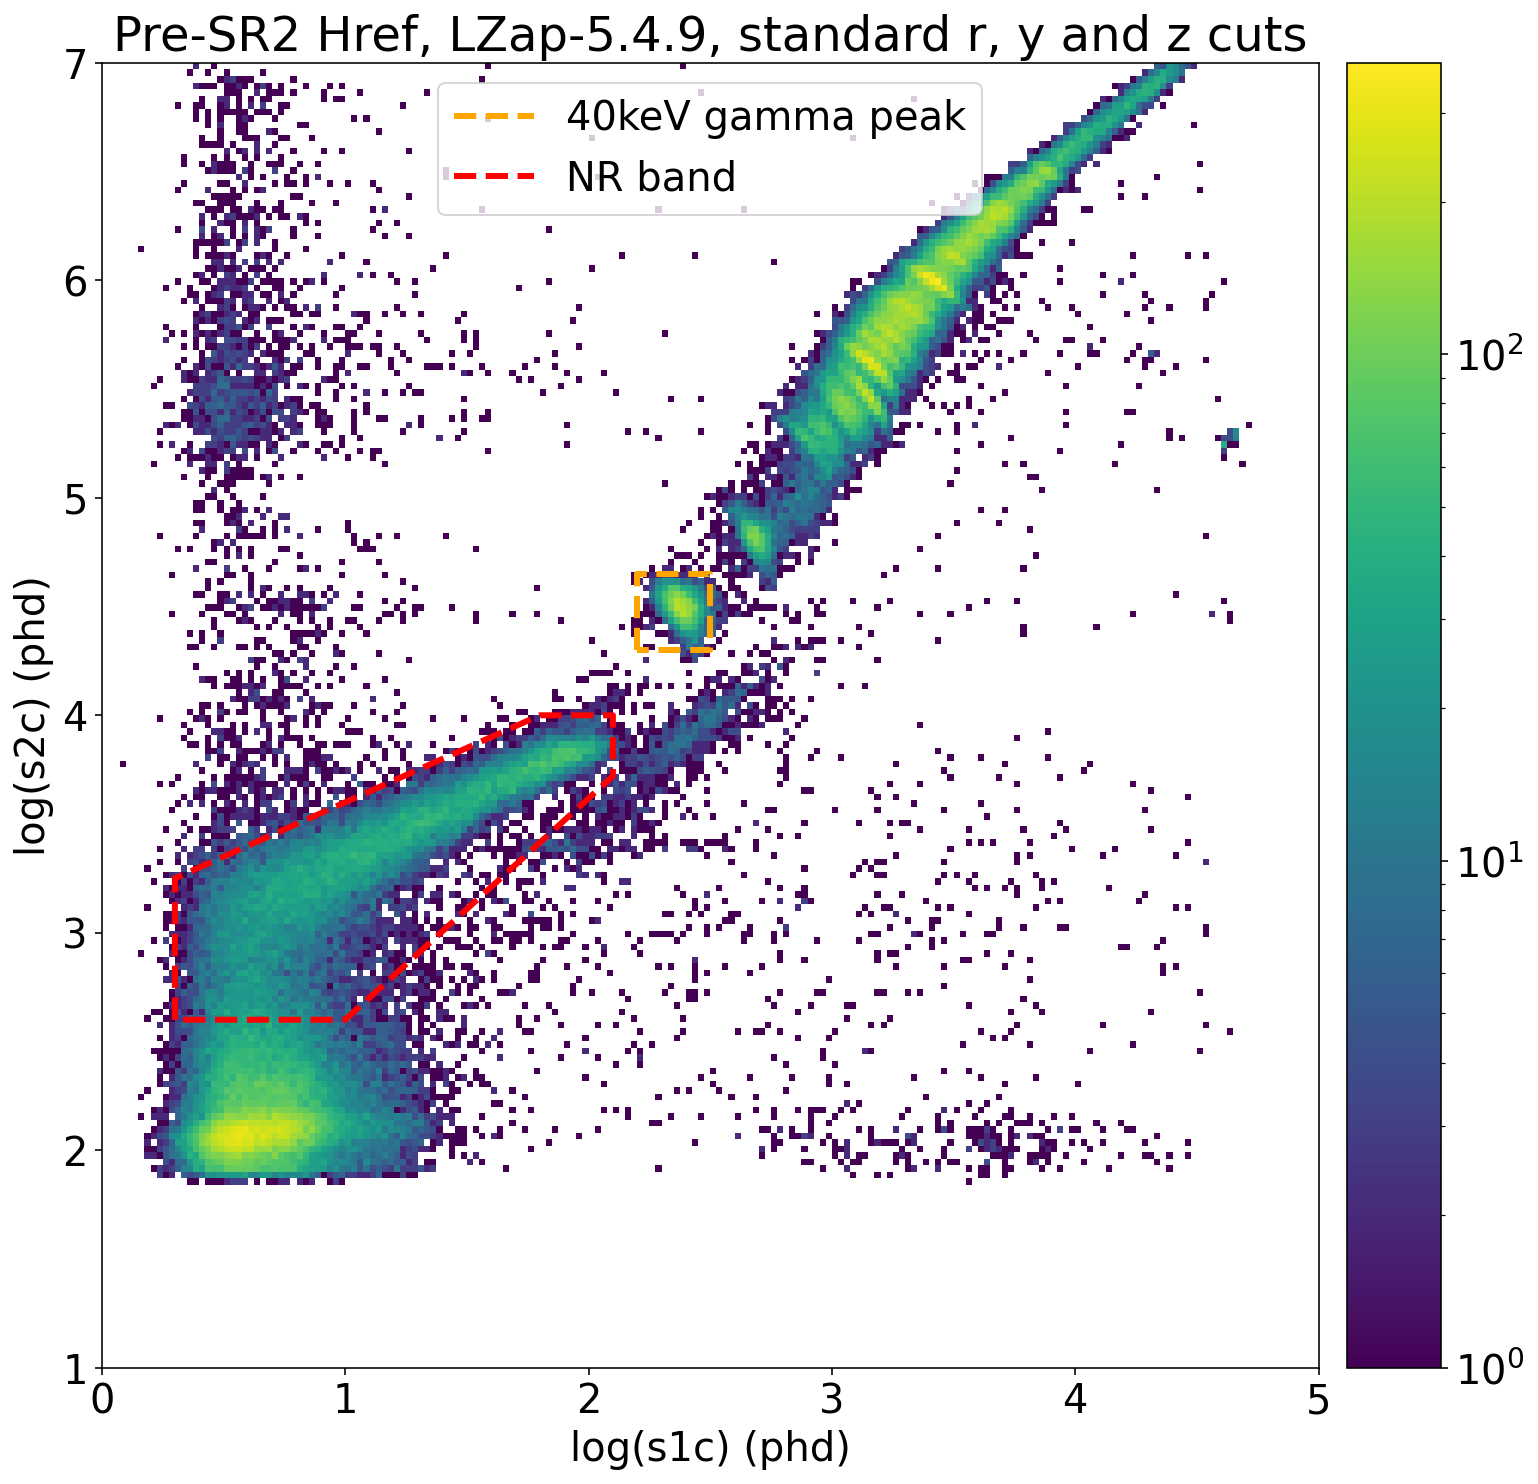

Events inside S1, S2 thresholds:  25405
Total events:  139488


In [51]:
fig = plt.figure(figsize=(12, 12))
plt.xlabel('log(s1c) (phd)')
plt.ylabel('log(s2c) (phd)')
plt.title('Pre-SR2 Href, LZap-5.4.9, standard r, y and z cuts') 
mplhep.hist2dplot(s1s2_hist_rcut_ycut_zcut, norm=LogNorm())
plt.plot(x_p,y_p,color='orange', linestyle='dashed', lw=3, label='40keV gamma peak')
plt.plot(x2_p,y2_p,color='red',linestyle='dashed', lw=3, label='NR band')
plt.legend(loc='upper center')
plt.show()

print("Events inside S1, S2 thresholds: ", inside_rcut_ycut_zcut)
print("Total events: ", total_rcut_ycut_zcut)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x1554ff754eb0>, cbar=<matplotlib.colorbar.Colorbar object at 0x1554f80550d0>, text=[])

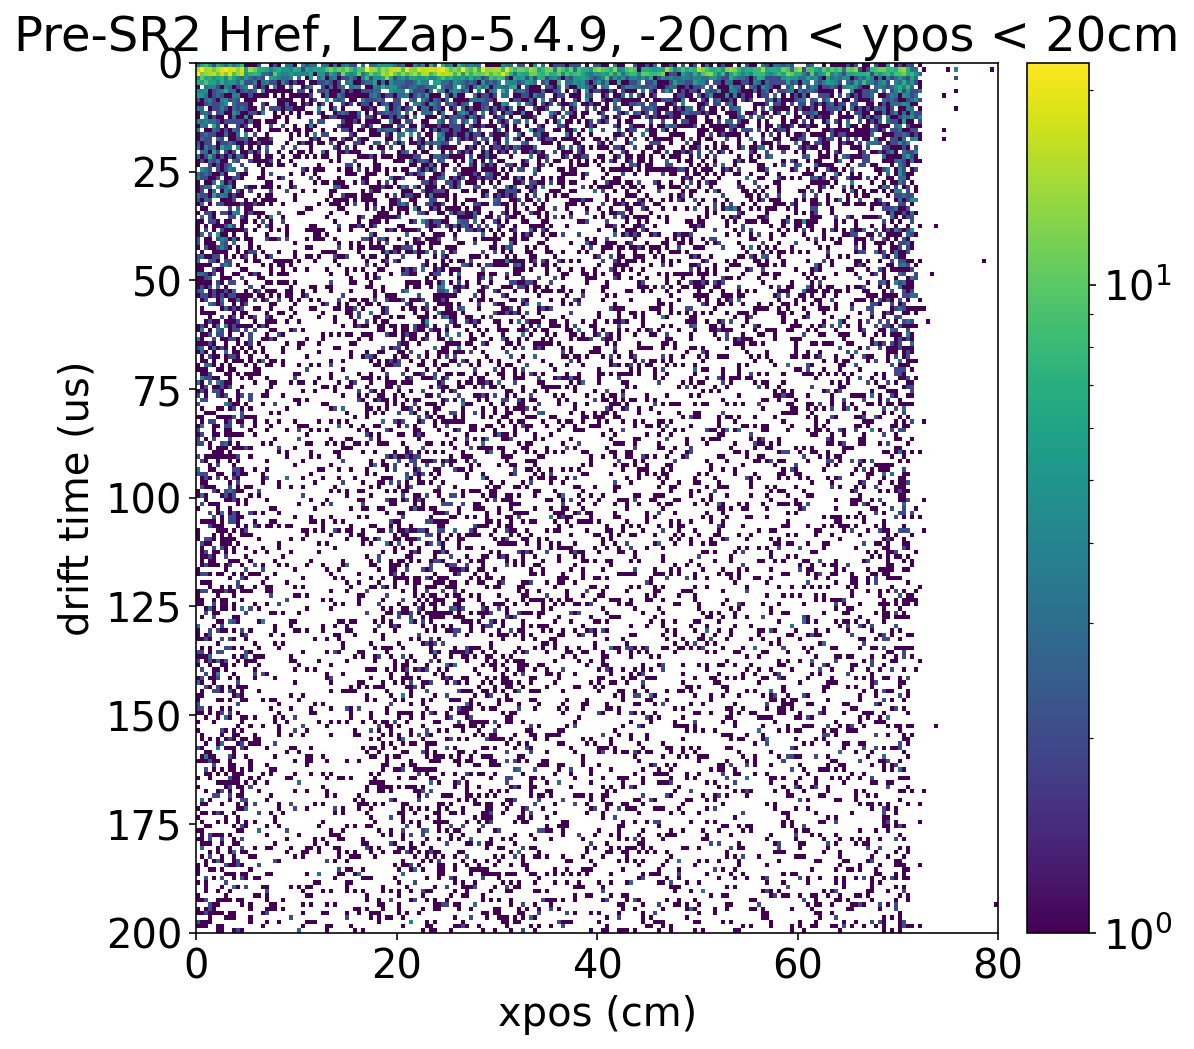

In [122]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('xpos (cm)')
plt.ylabel('drift time (us)')
plt.title('Pre-SR2 Href, LZap-5.4.9, -20cm < ypos < 20cm') 
mplhep.hist2dplot(xz_hist, norm=LogNorm())

Events inside S1, S2 thresholds:  9682
Total events:  966250


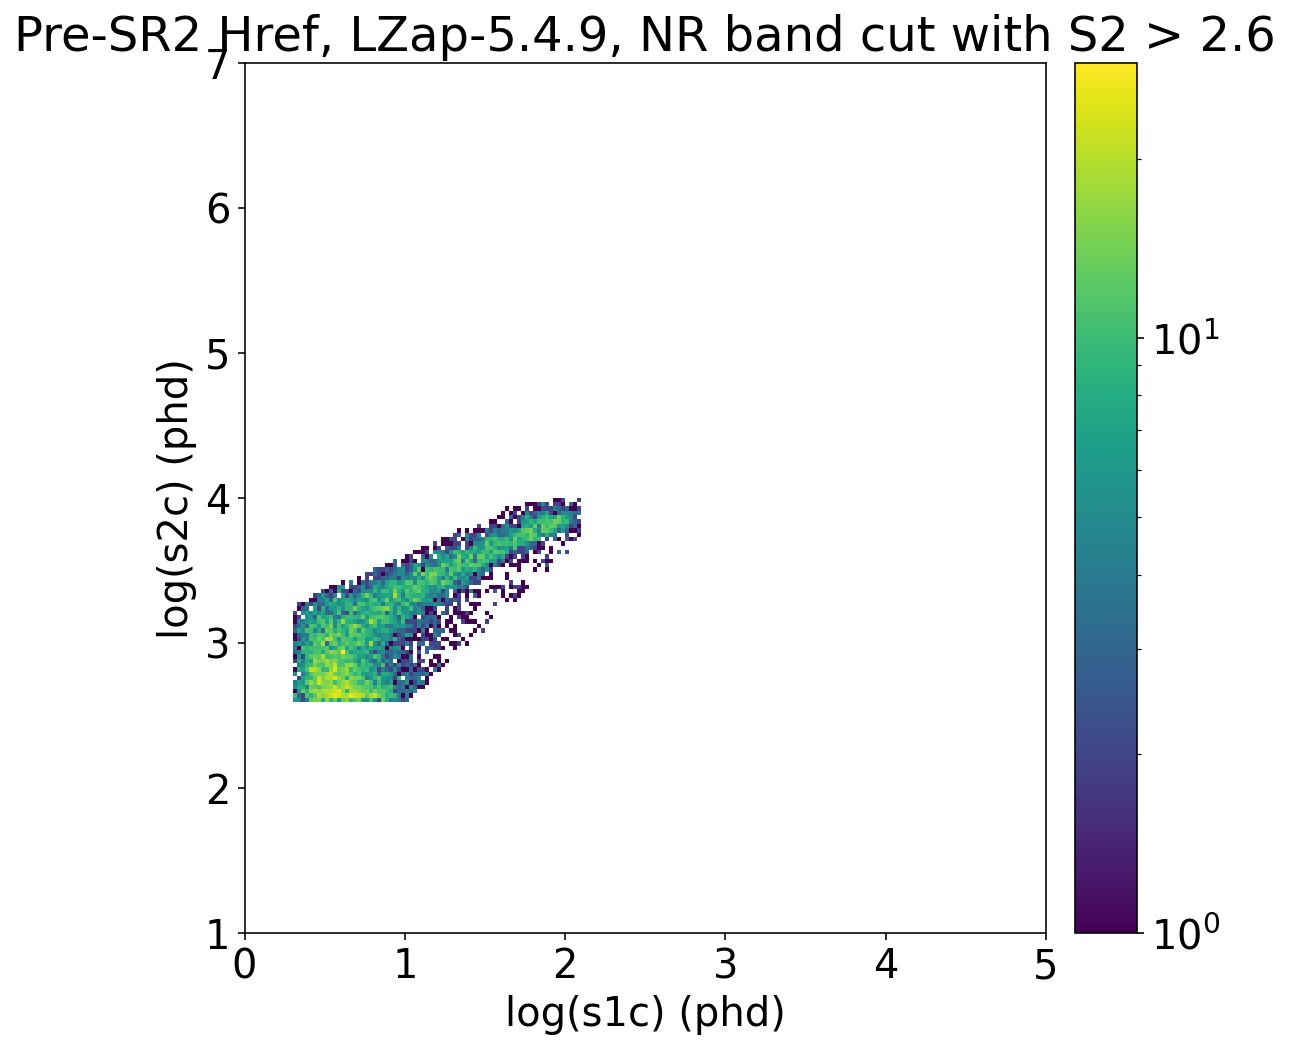

In [45]:
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(8, 8))
plt.xlabel('log(s1c) (phd)')
plt.ylabel('log(s2c) (phd)')
plt.title('Pre-SR2 Href, LZap-5.4.9, NR band cut with S2 > 2.6') 
mplhep.hist2dplot(s1s2_hist_nrcut, norm=LogNorm())

print("Events inside S1, S2 thresholds: ", inside_nocut)
print("Total events: ", total_nocut)

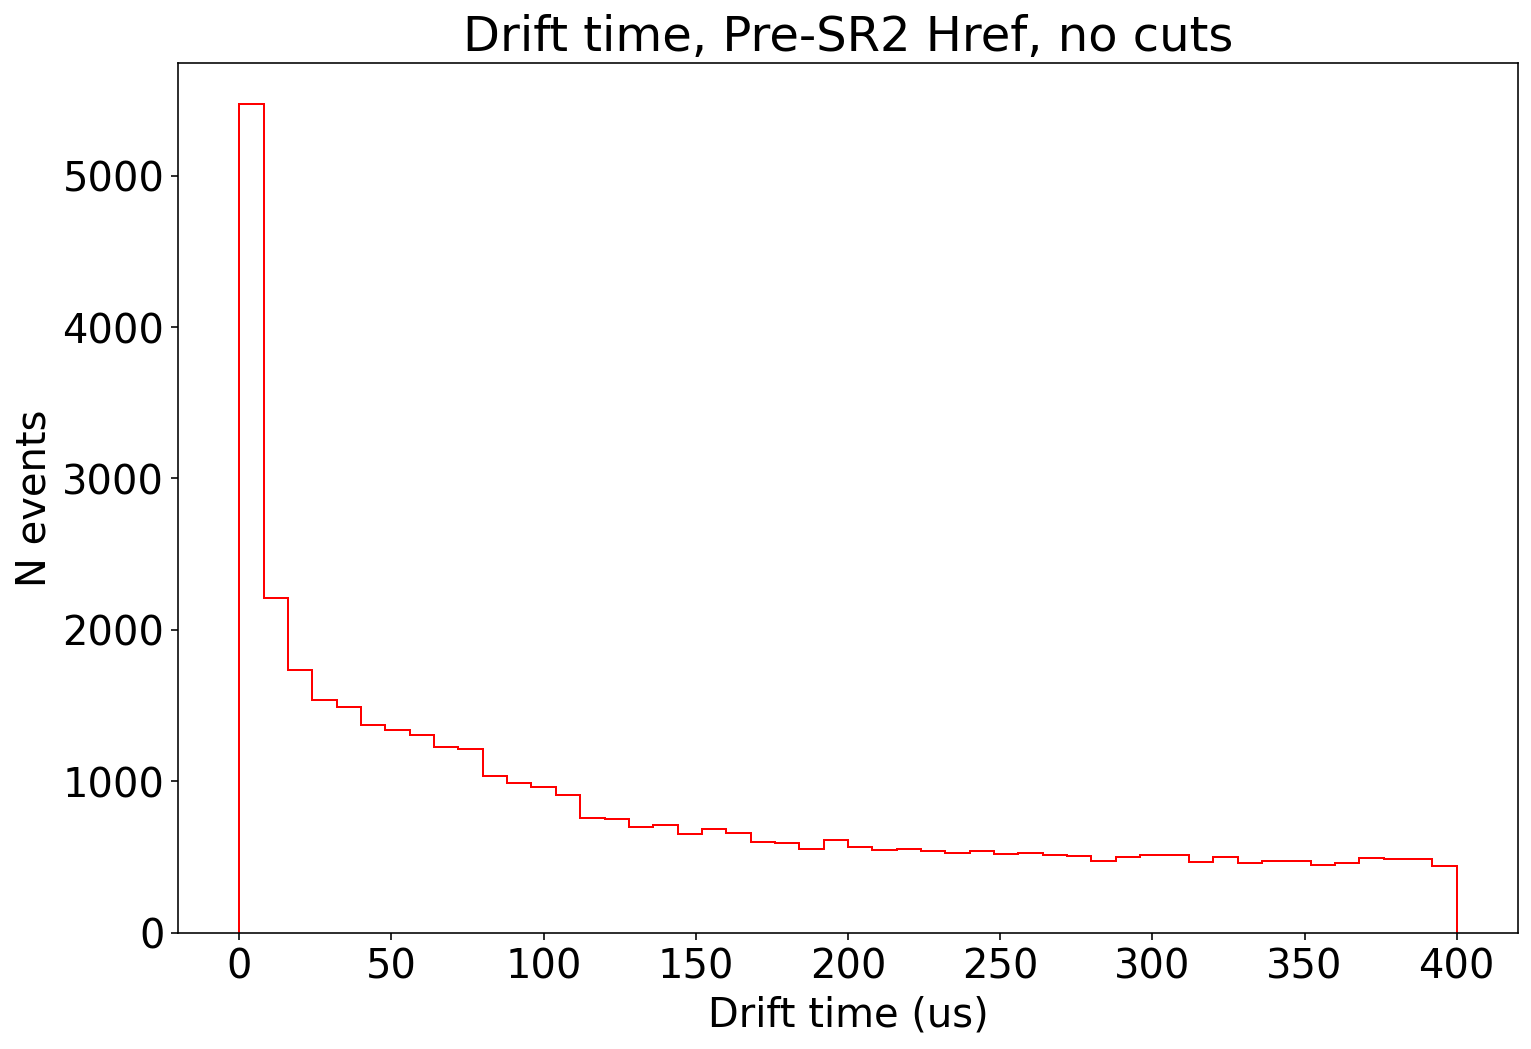

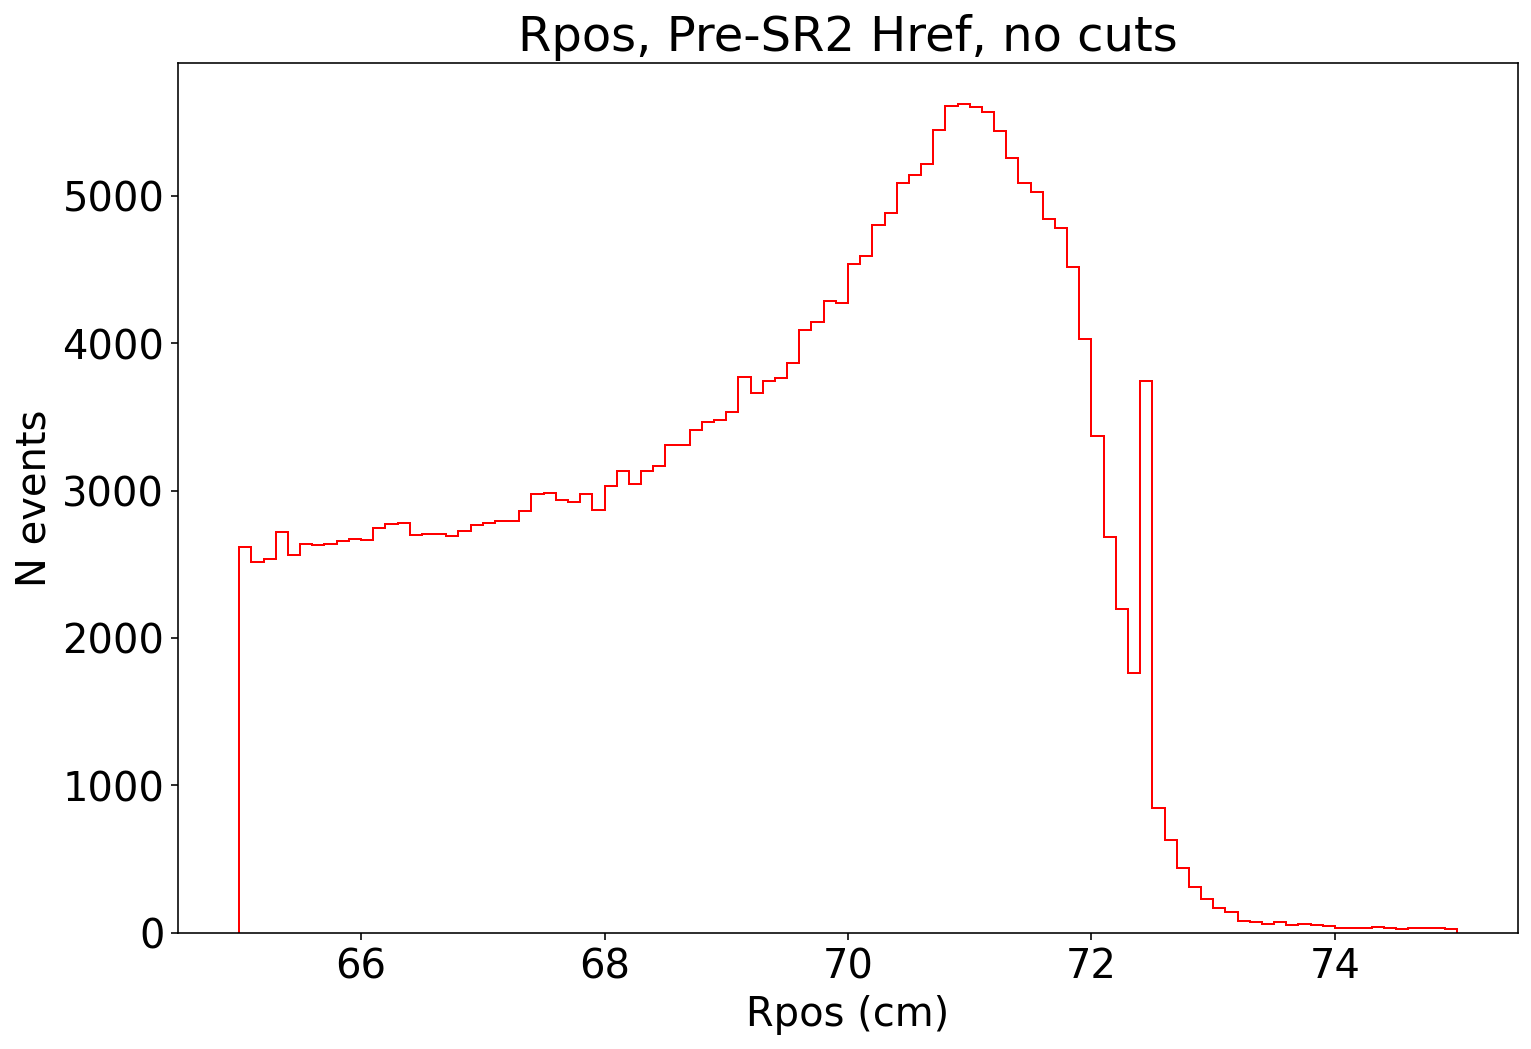

In [120]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (12,8))
plt.hist(drift_time_array, bins=50, range = (0,400), histtype='step', color='red')
plt.title("Drift time, Pre-SR2 Href, no cuts")
plt.xlabel("Drift time (us)")
plt.ylabel("N events")
plt.show()

plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (12,8))
plt.hist(rpos_array, bins=100, range = (65,75), histtype='step', color='red')
plt.title("Rpos, Pre-SR2 Href, no cuts")
plt.xlabel("Rpos (cm)")
plt.ylabel("N events")
plt.show()

In [4]:
#Analyze Href pulse signals from a basic perspective: for instance, create cdf of pulse size vs rate
rpos_lim = 67.5
rpos_lim_lower = 0
drift_time_lim = [10,120]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 20
b_lb = -20

#Parameters for isolating NR band with diagonal lines
a1 = 0.5
a2 = 0.6
c1 = 6.2
c2 = 4.1
pulse_size_array = []
total_time_counter = 0
n_pulses = 0

for i in range(len(dd_files)):
    if (i == 0):
        continue
    file = uproot.open(dd_files[i])
    
    s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
    pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
    pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
    pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')
    ss_cut = (file['Scatters;1']['ss./ss.nSingleScatters']==1)
    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    s1_corrected_area = file['Scatters']['ss./ss.correctedS1Area_phd'].array(library='np')
    s2_corrected_area = file['Scatters']['ss./ss.correctedS2Area_phd'].array(library='np')
    
    logs1c = np.log10(s1_corrected_area)
    logs2c = np.log10(s2_corrected_area)
    
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000
    
    rpos = np.sqrt(xpos**2 + ypos**2)

    rpos_cut = (rpos < rpos_lim) & (rpos > rpos_lim_lower) & (xpos < 0)
    y_cut = (ypos < 15) & (ypos > -15)
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])
    
    s1_area_cut = (s1_corrected_area > 2) & (s1_corrected_area < 10)
    #s2_area_cut = (np.log10(s2_corrected_area) > 2.8) & (np.log10(s2_corrected_area) < 3.4)
    s2_area_cut = (np.log10(s2_corrected_area) > 1)
    #s1_area_cut = (logs1c > 2.2) & (logs1c < 2.5)
    #s2_area_cut = (logs2c > 4.3) & (logs2c < 4.65)
    
    nr_cut = (logs2c/a1 - logs1c < c1) & (logs2c/a2 - logs1c > c2)
    
    s1_start_times = []
    
    for j in range(len(s1_pulse_id)):
        s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]])
    
    #Apply some cuts to get rid of the garbage
    

    #for j in range(len(pulseAreaExt)):
    pulseAreaExtNew = pulseAreaExt[s2_area_cut]
    pulseStartTimeNew = pulseStartTime[s2_area_cut]
    
    for j in range(len(pulseAreaExt)):
        #if (j%1 == 0):
            #print(n_pulses)
            #print(total_time_counter)
        for k in range(len(pulseAreaExt[j])):
            if (abs(pulseStartTime[j][k]) < 100000):
                try: 
                    pulse_size_array.append((pulseAreaExt[j][k]))
                    n_pulses += 1
                    #Difference in CE is a factor of 1.27 between pre-SR1 and pre-SR2
                except:
                    continue
        try:
            #total_time_counter += (pulseStartTime[j][-1] - pulseStartTime[j][0])
            total_time_counter += (200000)
        except:
            continue
            
        
    if ((i % 100) == 0):
        print("Done with file ", i)
        break
    #print(xpos)
    #print(ypos)
print(n_pulses)
print(total_time_counter)

/tmp/ipykernel_184543/1117584244.py:35: RuntimeWarning: invalid value encountered in log10
  logs1c = np.log10(s1_corrected_area)
/tmp/ipykernel_184543/1117584244.py:36: RuntimeWarning: invalid value encountered in log10
  logs2c = np.log10(s2_corrected_area)
/tmp/ipykernel_184543/1117584244.py:48: RuntimeWarning: invalid value encountered in log10
  s2_area_cut = (np.log10(s2_corrected_area) > 1)
/tmp/ipykernel_184543/1117584244.py:40: RuntimeWarning: overflow encountered in square
  rpos = np.sqrt(xpos**2 + ypos**2)


KeyboardInterrupt: 

Total ns/pulse:  3744.6725501568408


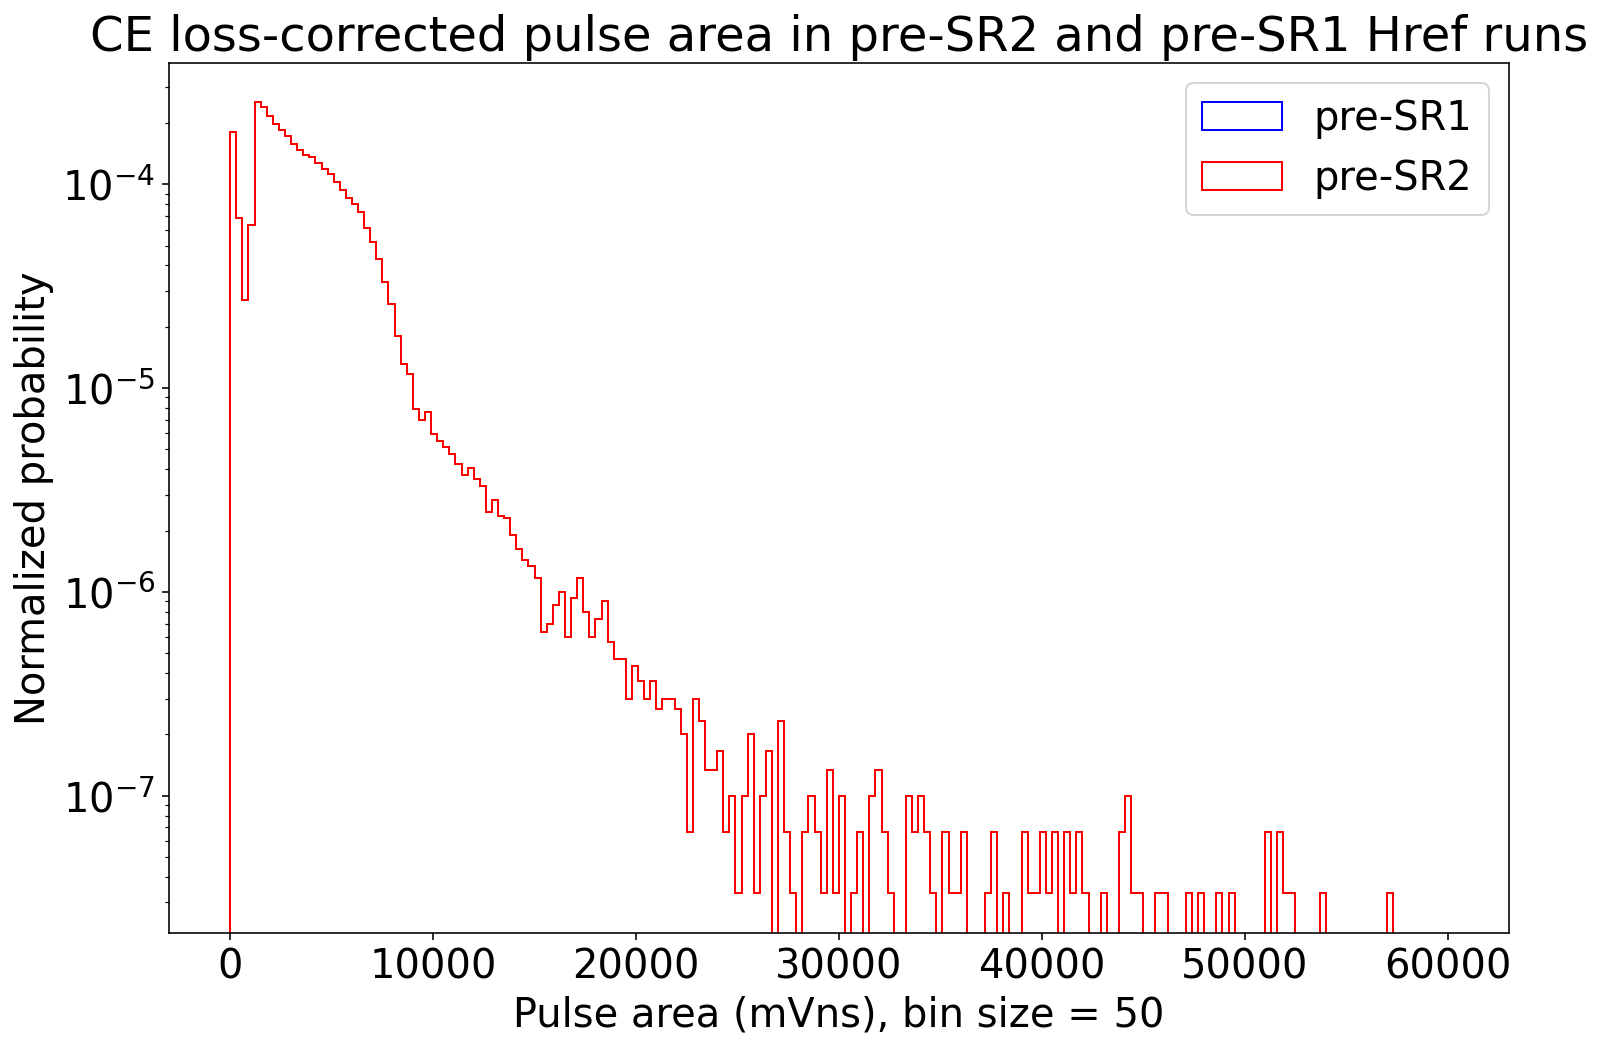

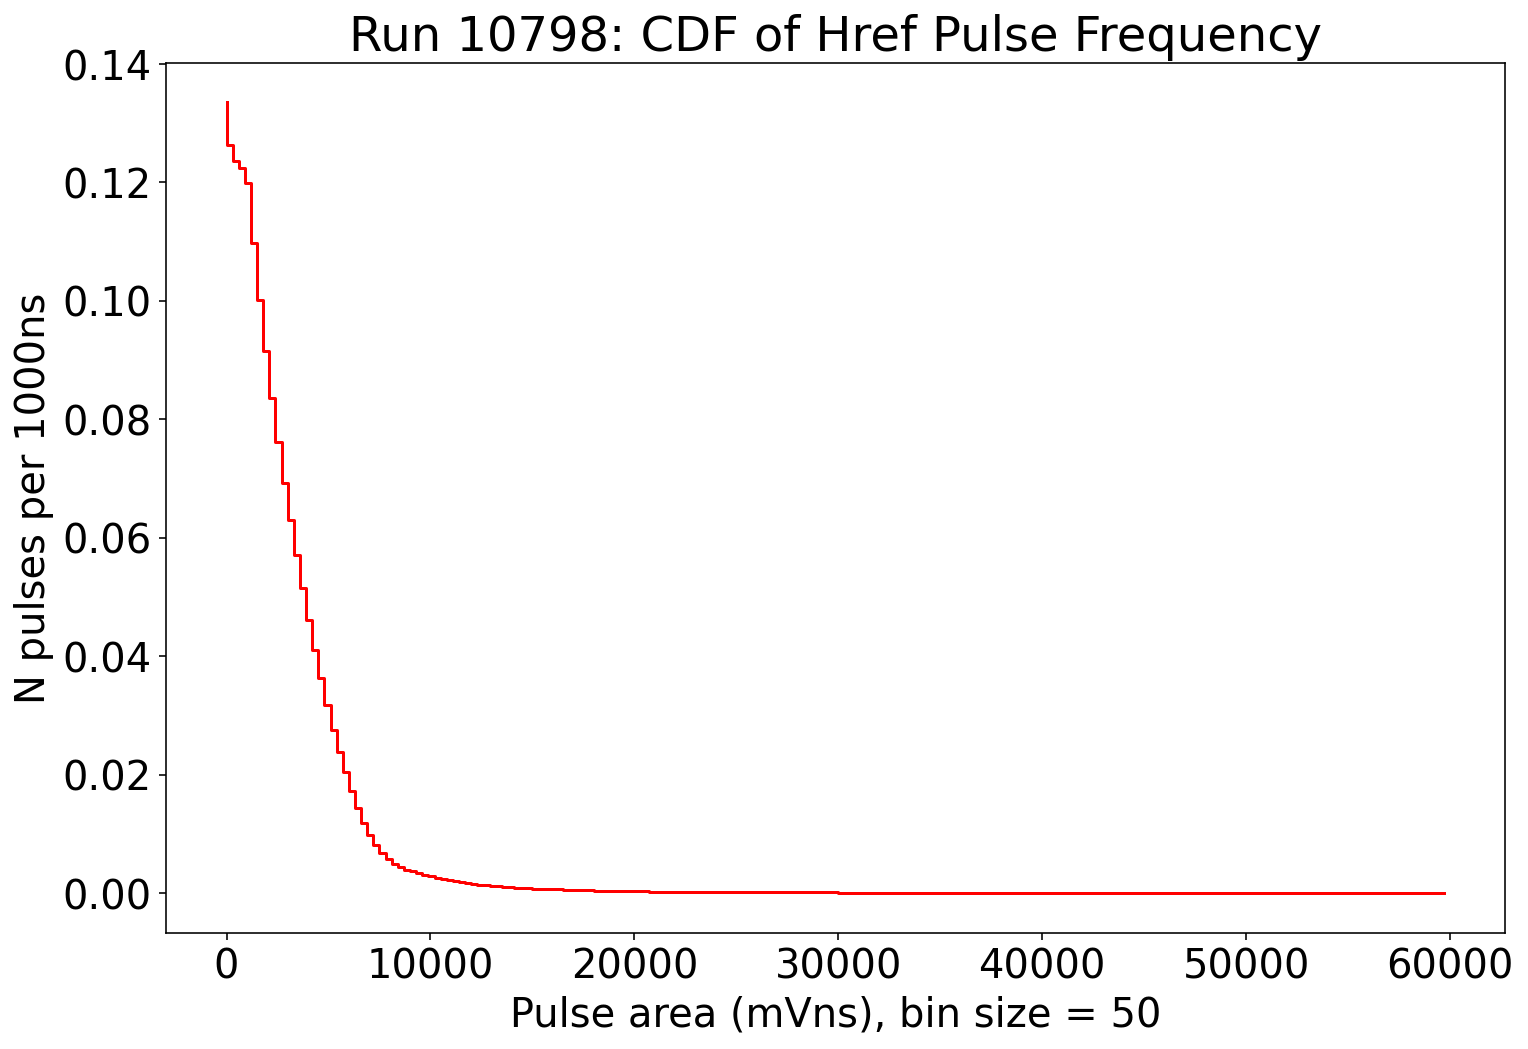

Total ns/pulse:  3744.6725501568408
36000.0 51000.0
6.008536046511628e-05 1.3352302325581396e-05


In [9]:
print("Total ns/pulse: ", total_time_counter/n_pulses)
#Create cdf of pulse height

endpoint = 60000
n_bins = 200
cutoffs = []
n_events = 200000
bins = np.zeros(n_bins)
for i in range(n_bins):
    cutoffs.append((endpoint*i)/n_bins)

#print(cutoffs)
pulse_size_array_reduced = np.array(pulse_size_array[0:100000])
presr2_data = pulse_size_array_reduced
plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (12,8))
plt.hist(pulse_size_array_reduced, bins=n_bins, range=(0,endpoint), histtype='step', color='blue', label='pre-SR1', density=10000)
plt.hist(presr2_data, bins=n_bins, range=(0,endpoint), histtype='step', color='red', label='pre-SR2', density=10000)
plt.title("CE loss-corrected pulse area in pre-SR2 and pre-SR1 Href runs")
plt.yscale('log')
plt.xlabel('Pulse area (mVns), bin size = 50')
plt.ylabel('Normalized probability')
plt.legend(loc='upper right')
plt.show()

for i in range(len(bins)):
    pulse_size_cut = (pulse_size_array_reduced > cutoffs[i])
    bins[i] = len(pulse_size_array_reduced[pulse_size_cut])/n_events

#print(bins)
#plt.bar(cutoffs, bins)
#plt.show()

#print(cutoffs)
plt.figure(figsize = (12,8))
plt.step(cutoffs, bins/((total_time_counter/n_pulses)/1000), color='red')
#width=(endpoint/n_bins)
plt.title("Run 10798: CDF of Href Pulse Frequency")
plt.xlabel("Pulse area (mVns), bin size = 50")
plt.ylabel("N pulses per 1000ns")
plt.show()

print("Total ns/pulse: ", total_time_counter/n_pulses)
print(cutoffs[120], cutoffs[170])
print((bins/((total_time_counter/n_pulses)/1000))[120], (bins/((total_time_counter/n_pulses)/1000))[170])

In [48]:
file = uproot.open(dd_files[1])

s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')

s1_start_times = []

for j in range(len(s1_pulse_id)):
    s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]])
    
print(pulseStartTime[12])
print(s1_start_times[12])


[-1098540 -1090620 -1090450 -1090350 -1089280 -1088100 -1085750 -1085110
 -1079850 -1074240 -1062830 -1062750 -1056380 -1056170 -1053320 -1043980
 -1042690 -1037240 -1027000 -1024690 -1021810 -1012860 -1001340  -998520
  -991680  -986730  -980440  -978230  -978160  -971450  -962470  -958380
  -954250  -948940  -940400  -927400  -927270  -920450  -919880  -914370
  -910760  -906000  -902680  -886560  -886440  -881840  -876150  -875970
  -858730  -853300  -848790  -836300  -830250  -827260  -789660  -780910
  -775920  -762160  -761400  -761300  -758800  -758580  -753320  -753250
  -749920  -744720  -744460  -730240  -719360  -698240  -693190  -692790
  -689850  -687980  -680510  -676310  -676220  -675570  -660750  -652330
  -643250  -641600  -635420  -612200  -610330  -603380  -595540  -586750
  -584290  -582900  -582840  -563260  -558070  -549350  -542110  -536590
  -529170  -519870  -519780  -508700  -508380  -498410  -497610  -490980
  -490010  -488480  -480020  -478610  -477300  -471

[1499790, 1499220, 1439570, 1498920, 1497070, 1496830, 1493340, 1484110, -823290, -1300, 1499440, 1499300, 1499650, -1290, 1499520, 1499730, -1300, 1498960, -1380, 1497450, -1280, 1499170, 1416140, -475520, 1499120, -1390, 1495990, 1497880, 1499900, 1497710, -237420, 509200, -73570, 1499750, -354620, 1497720, 1498450, 1499380, 1497510, 1498430, -465920, 1498480, 1497560, 1499430, 1494660, 1496660, -1420, 1499590, 1499520, -1430, 1498370, 1495410, 1499900, 1493690, 1499520, 1499630, -1520, 242440, -728750, 1496930, 1498320, -686020, -1460, -1510, 1451840, -1031460, 1497460, 1497200, 1491910, 1356680, -112170, 1498880, 1495660, 1497460, 1498130, 1499560, 1495690, 1498700, 1497750, 1496820, 1499760, 1495410, 1479240, 1499690, 1490080, 1495210, 1486270, 1499780, 1495810, -1380, 1495880, 1488110, 1498340, 1494900, 1498970, 1495300, 1499540, -1300, 1444820, 1499470]


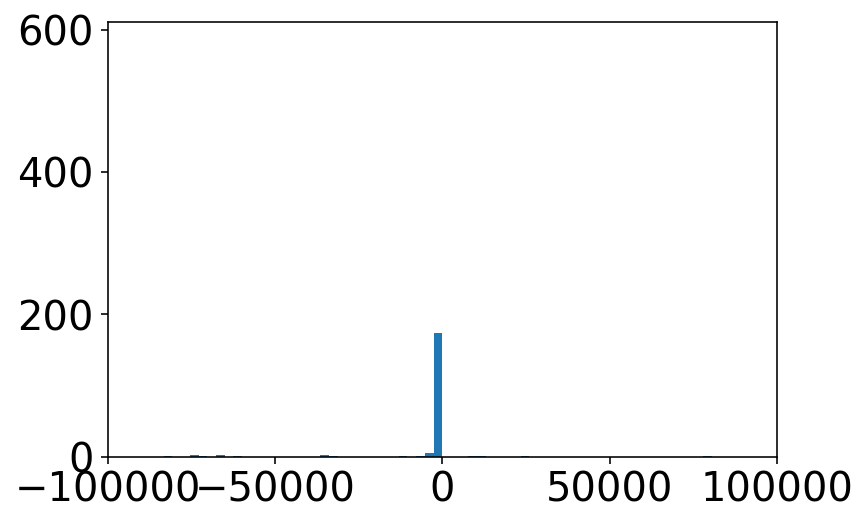

In [56]:
plt.hist(s1_start_times, bins=1000)
plt.xlim(-100000, 100000)
print(s1_start_times[0:100])

In [11]:
#Calculate formula for E_dep based on only S2 signal

def GetYieldNR(energy, density=2.8811, dfield=192., NuisParam=[11.,1.1,0.0480,-0.0533,12.6,0.3,2.,0.3,2.,0.5,1.,1.]):
    # from https://github.com/NESTCollaboration/nest/blob/master/src/NEST.cpp, line 713 YieldResult NESTcalc::GetYieldNR
    DENSITY = 2.9
    Nq = NuisParam[0] * np.power(energy, NuisParam[1])
    ThomasImel = NuisParam[2] * np.power(dfield, NuisParam[3]) * np.power(density / DENSITY, 0.3)
    Qy = 1. / (ThomasImel * np.power(energy + NuisParam[4], NuisParam[9]))
    Ly = Nq / energy - Qy
    Qy = np.where(Qy < 0.0, 0.0, Qy)
    Ly = np.where(Ly < 0.0, 0.0, Ly)
    Ne = Qy * energy
    Nph = Ly * energy 
    Nq = Nph + Ne
    return Ly, Qy, Nph, Ne, Nq

print(GetYieldNR(energy=20))

(array(10.00371079), array(4.83840054), 200.07421574203158, 96.76801074615241, 296.842226488184)


<Figure size 864x576 with 0 Axes>

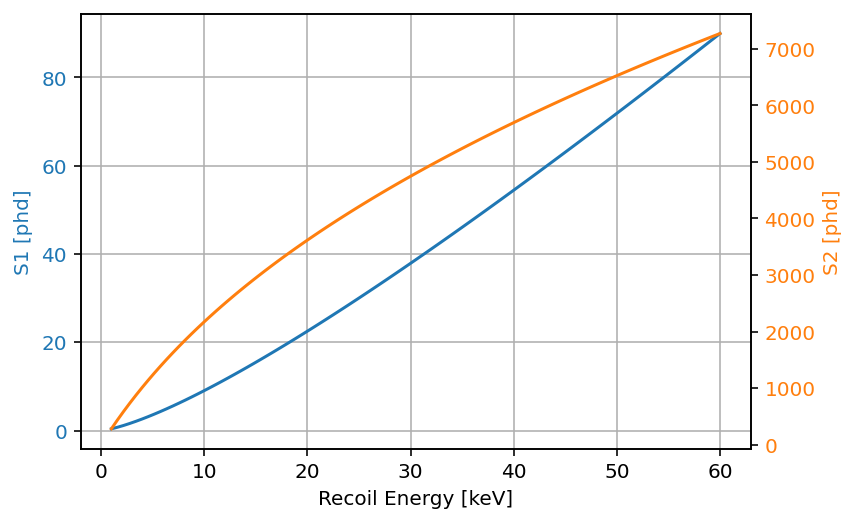

In [12]:
g1 = 0.1125
g2 = 37.38

energy_yplot = np.linspace(1,60,100)
Ly, Qy, Nph, Ne, Nq=GetYieldNR(energy_yplot)

plt.figure(figsize=(12,8))
fig,ax1=plt.subplots(1,1)
line1 = ax1.plot(energy_yplot,Nph*g1,label='S1',color='C0')
ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('S1 [phd]',color='C0')
ax1.tick_params('y',labelcolor='C0')
ax1.grid()
ax2=ax1.twinx()
line2=ax2.plot(energy_yplot,Ne*g2,label='S2',color='C1')
ax2.set_ylabel('S2 [phd]',color='C1')
ax2.tick_params('y',labelcolor='C1')
plt.show()


9.001687204420671


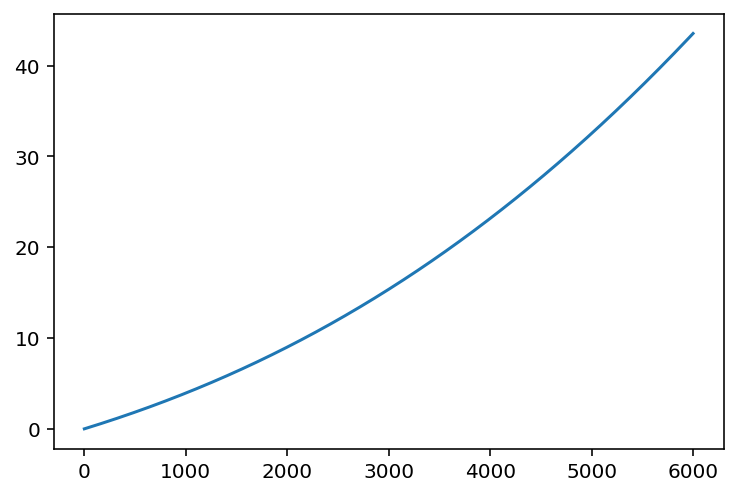

In [13]:
from scipy.interpolate import CubicSpline

S2 = Ne*g2
spl = CubicSpline(S2, energy_yplot)

x = np.linspace(0,6000, 1000)

plt.plot(x, spl(x))

print(spl(2000))

In [20]:
#Look for coincident signals
pulse_size_array = []
pulse_times_array = []
pulse_size_array_last = []
pulse_times_array_last = []
E_dep_cut_array_all = []
E_dep_cut_array = []
E_dep_old_cut_array = []
total_time_counter = 0
n_pulses = 0

a = 11
b = 1.1
#These next values are for 9kV
#g1 = 0.1080
#g2 = 58.18

g1 = 0.1125
g2 = 37.38

rpos_lim = 69.5
rpos_lim_lower = 0
drift_time_lim = [10,120]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 15
b_lb = -15

#Parameters for isolating NR band with diagonal lines
a1 = 0.5
#a2 = 0.6
c1 = 6.2
#c2 = 4.1

#s2 > 2.6
a2 = 1.02
c2 = 1.55

for i in range(len(dd_files)):
    if (i == 0):
        continue
    file = uproot.open(dd_files[i])
    
    #print("Saving file characteristics")
    
    s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
    pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
    areaFractionTime10 = file['Events']['pulsesTPC./pulsesTPC.areaFractionTime10_ns'].array(library='np')
    pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
    pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')
    s1_corrected_area = file['Scatters']['ss./ss.correctedS1Area_phd'].array(library='np')
    s2_corrected_area = file['Scatters']['ss./ss.correctedS2Area_phd'].array(library='np')
    
    #ss_cut = (file['Scatters;1']['ss./ss.nSingleScatters']==1)
    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000
    
    rpos = np.sqrt(xpos**2 + ypos**2)

    #print("Starting basic cuts")
    
    rpos_cut = (rpos < rpos_lim) & (rpos > rpos_lim_lower) & (xpos < 0)
    #y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    y_cut = (ypos < 15) & (ypos > -15)
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])
    
    logs1c = np.log10(s1_corrected_area)
    logs2c = np.log10(s2_corrected_area)
    
    #E_dep_old = (((s1_corrected_area/g1)+(s2_corrected_area/g2))/11)**(1/1.1)
    E_dep = spl(s2_corrected_area)
    
    #drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000
    
    #rpos = np.sqrt(xpos**2 + ypos**2)

    #rpos_cut = (rpos < rpos_lim) & (rpos > rpos_lim_lower) & (xpos < 0)
    #y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    #y_cut = (ypos < 15) & (ypos > -15)
    #z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])
    
    s1_area_cut = (s1_corrected_area > 2) & (s1_corrected_area < 125)
    s2_area_cut = (np.log10(s2_corrected_area) > 2.6) & (np.log10(s2_corrected_area) < 4)
    #s1_area_cut = (s1_corrected_area > 2) & (s1_corrected_area < 10)
    #s2_area_cut = (np.log10(s2_corrected_area) > 2.8) & (np.log10(s2_corrected_area) < 3.4)
    
    #40keV gamma response
    #s1_area_cut = (logs1c > 2.2) & (logs1c < 2.5)
    #s2_area_cut = (logs2c > 4.3) & (logs2c < 4.65)
    
    nr_cut = (logs2c/a1 - logs1c < c1) & (logs2c/a2 - logs1c > c2)
    s1_start_times = []
    
    #print("Looping s1 start times")
    
    for j in range(len(s1_pulse_id)):
        s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]] + areaFractionTime10[j][s1_pulse_id[j]])
        
    s1_start_times = np.array(s1_start_times)
    pulseAreaExtNew = pulseAreaExt[s1_area_cut&s2_area_cut&nr_cut&rpos_cut&y_cut&z_cut]
    pulseStartTimeNew = (pulseStartTime[s1_area_cut&s2_area_cut&nr_cut&rpos_cut&y_cut&z_cut]) 
    s1_start_times_new = (s1_start_times[s1_area_cut&s2_area_cut&nr_cut&rpos_cut&y_cut&z_cut])
    #E_dep_old_new = E_dep_old[s1_area_cut&s2_area_cut&nr_cut&rpos_cut&y_cut&z_cut]
    E_dep_new = E_dep[s1_area_cut&s2_area_cut&nr_cut&rpos_cut&y_cut&z_cut]
   
    #pulseAreaExtNew = pulseAreaExt[s1_area_cut&s2_area_cut]
    #pulseStartTimeNew = pulseStartTime[s1_area_cut&s2_area_cut]
    #s1_start_times_new = s1_start_times[s1_area_cut&s2_area_cut]
    #E_dep_new = E_dep[s1_area_cut&s2_area_cut]    
    
    for j in range(len(E_dep_new)):
        E_dep_cut_array.append(E_dep_new[j])
        #E_dep_old_cut_array.append(E_dep_old_new[j])
        
    #print("Finding coincident pulses")
        
    for j in range(len(pulseAreaExtNew)):
        pulse_size_last = 0
        pulse_times_last = -100000
        for k in range(len(pulseAreaExtNew[j])):
            if (abs(pulseStartTimeNew[j][k] - (s1_start_times_new[j] + 300)) < 10000):
                if (pulseStartTimeNew[j][k] < (s1_start_times_new[j] + 300)):
                    try:
                        pulse_size_last = pulseAreaExtNew[j][k]
                        pulse_times_last = (pulseStartTimeNew[j][k] - (s1_start_times_new[j] + 300))
                    except:
                        continue
                try: 
                    pulse_size_array.append((pulseAreaExtNew[j][k]))
                    pulse_times_array.append((pulseStartTimeNew[j][k] - (s1_start_times_new[j] + 300)))
                    E_dep_cut_array_all.append(E_dep_new[j])
                    n_pulses += 1
                    #Difference in CE is a factor of 1.27 between pre-SR1 and pre-SR2
                except:
                    continue
        pulse_size_array_last.append(pulse_size_last)
        pulse_times_array_last.append(pulse_times_last)
        #np.append(pulse_size_array_last, pulse_size_last)
        #np.append(pulse_times_array_last, pulse_times_last)
        #try:
            #total_time_counter += (pulseStartTime[j][-1] - pulseStartTime[j][0])
        #except:
            #continue
        
    if ((i % 10) == 0):
        print("Done with file ", i)
    #print(xpos)
    #print(ypos)

print(len(pulse_size_array))
print(len(pulse_times_array))
print(len(E_dep_cut_array_all))
print(len(pulse_size_array_last))
print(len(pulse_times_array_last))
print(len(E_dep_cut_array))


/tmp/ipykernel_136724/2969267173.py:70: RuntimeWarning: invalid value encountered in log10
  logs1c = np.log10(s1_corrected_area)
/tmp/ipykernel_136724/2969267173.py:71: RuntimeWarning: invalid value encountered in log10
  logs2c = np.log10(s2_corrected_area)
/tmp/ipykernel_136724/2969267173.py:86: RuntimeWarning: invalid value encountered in log10
  s2_area_cut = (np.log10(s2_corrected_area) > 2.6) & (np.log10(s2_corrected_area) < 4)
/tmp/ipykernel_136724/2969267173.py:61: RuntimeWarning: overflow encountered in square
  rpos = np.sqrt(xpos**2 + ypos**2)


Done with file  10
Done with file  20
Done with file  30
Done with file  40
Done with file  50
Done with file  60
Done with file  70
Done with file  80
Done with file  90
Done with file  100
Done with file  110
Done with file  120
Done with file  130
Done with file  140
Done with file  150
Done with file  160
Done with file  170
Done with file  180
Done with file  190
Done with file  200
Done with file  210
Done with file  220
Done with file  230
Done with file  240
Done with file  250
Done with file  260
Done with file  270
Done with file  280
Done with file  290
Done with file  300
Done with file  310
Done with file  320
Done with file  330
Done with file  340
Done with file  350
Done with file  360
Done with file  370
Done with file  380
Done with file  390
Done with file  400
Done with file  410
Done with file  420
Done with file  430
Done with file  440
Done with file  450
Done with file  460
Done with file  470
Done with file  480
Done with file  490
Done with file  500
Done with

6807
122649
122649
122649
25405
25405
25405


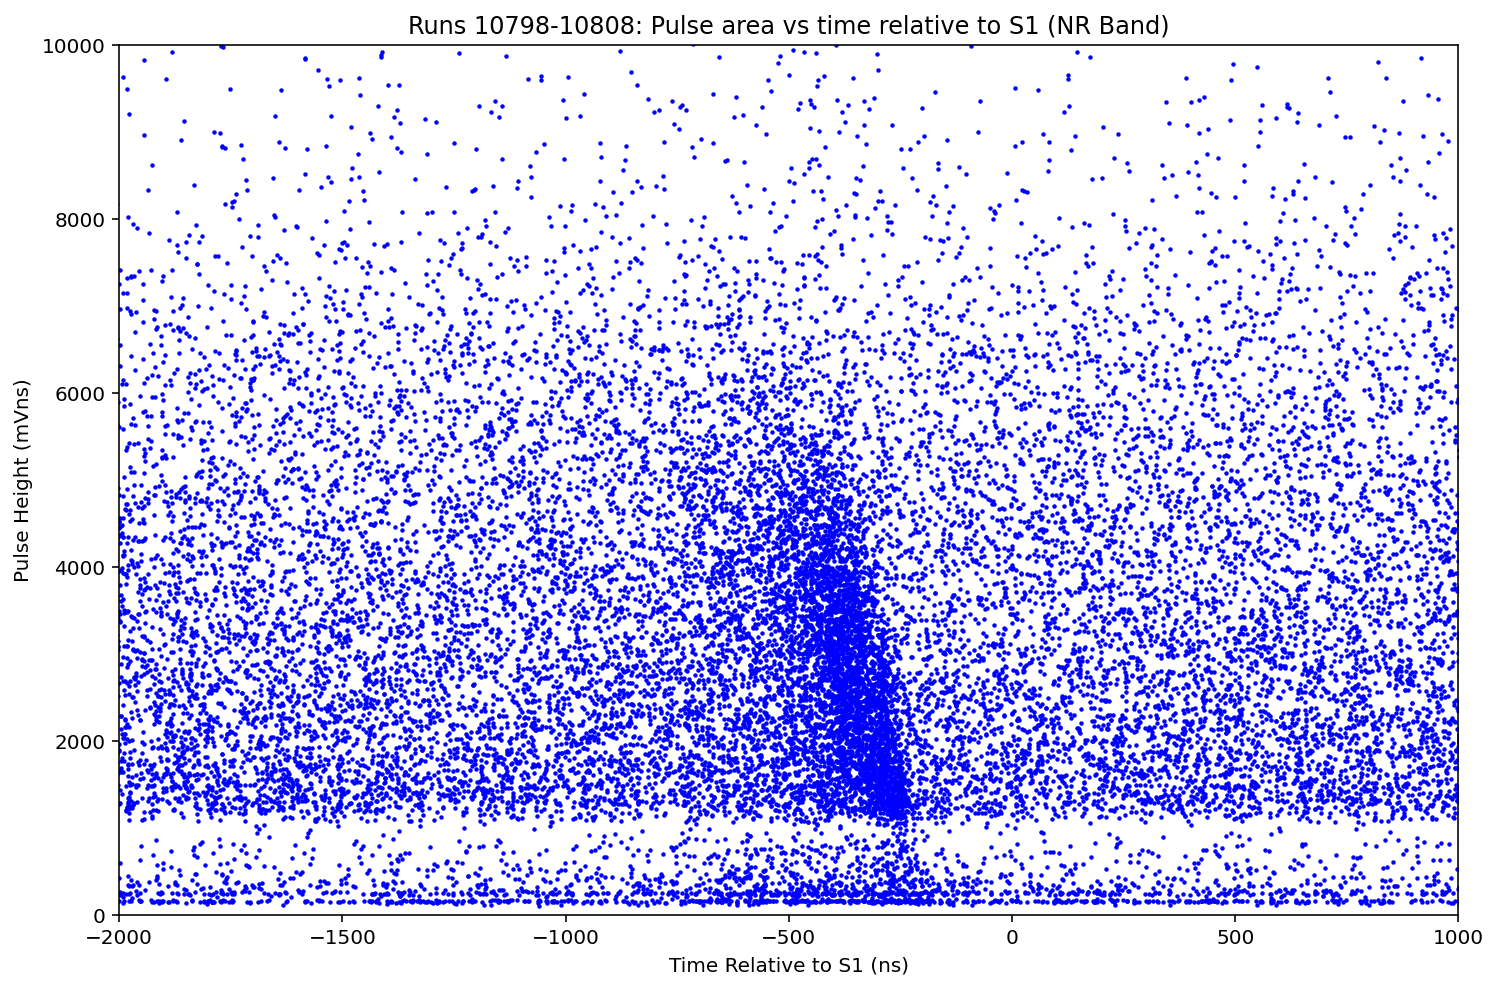

In [23]:
pulse_times_array_fuzzy = pulse_times_array + np.random.normal(loc=0,scale=4,size=len(pulse_times_array))

#pulse_size_array = np.array(pulse_size_array)
print(i)
#pulse_size_cut = (pulse_size_array_last > 2000)

plt.figure(figsize=(12,8))
plt.scatter(pulse_times_array_fuzzy, pulse_size_array, s=1.5, color='blue')
plt.title("Runs 10798-10808: Pulse area vs time relative to S1 (NR Band)")
plt.ylim(0, 10000)
plt.xlim(-2000, 1000)
plt.xlabel("Time Relative to S1 (ns)")
plt.ylabel("Pulse Height (mVns)")

print(len(pulse_size_array))
print(len(pulse_times_array))
print(len(E_dep_cut_array_all))
print(len(pulse_size_array_last))
print(len(pulse_times_array_last))
print(len(E_dep_cut_array))

122649
122649
25405
25405
25405
[ 1.14997557 -0.39454908 -0.39143012 -0.82457196 -0.35336558 -0.36636978
  0.24811161 -0.10032366 -0.88127607 -0.26744599 -0.76724886  0.67145042
 -0.38717107  0.18934949  0.21738866 -0.04147446 -0.79270862  0.59282873
  0.99923661 -0.18274275 -1.04057798 -0.14269799 -0.07886294  0.98219353
 -0.70147279 -0.4870922  -0.17134534  0.41692422  0.37060596  0.2000274
 -0.09526985  0.09153026  0.09109505 -0.11636485  0.06037858  1.03147067
  0.3349003   1.09571646  0.22945779 -0.48044442 -0.05580468  0.07997074
 -0.13148238  0.24049782  0.36776907 -0.35589609  0.51595509 -0.06548686
  0.37872763  0.22839092 -0.57543736 -0.10989489  0.59958404 -0.76873264
  0.31641192 -1.12161645  0.12355899 -0.6788899   0.04223537 -0.06780972
  0.28130934 -0.57606548 -0.50958023 -0.46536649  0.20480345 -0.03040143
  0.20585409  0.70248234  1.25381194  0.48459127  0.07490522  0.12394979
 -0.03339045 -0.17674513  0.633922   -0.1498402  -1.1717692  -0.40252459
  0.43555399 -0.1683

(array([ 16.,  61., 163., 233., 264., 156.,  75.,  24.,   7.,   1.]),
 array([-1.35862947, -1.02709942, -0.69556938, -0.36403934, -0.03250929,
         0.29902075,  0.6305508 ,  0.96208084,  1.29361088,  1.62514093,
         1.95667097]),
 <BarContainer object of 10 artists>)

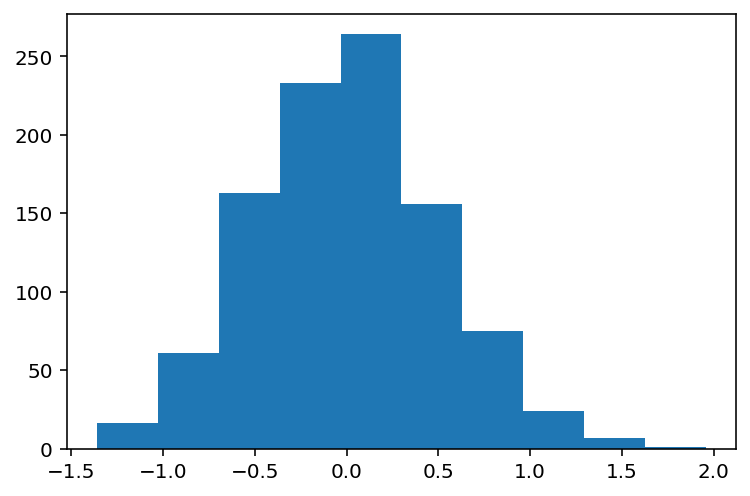

In [24]:
print(len(pulse_size_array))
print(len(pulse_times_array))
print(len(pulse_size_array_last))
print(len(pulse_times_array_last))
print(len(E_dep_cut_array))
print(np.random.normal(loc=0,scale=1/2,size=len(pulse_times_array_last))[0:100])
plt.hist(np.random.normal(loc=0,scale=1/2,size=len(pulse_times_array_last))[0:1000])

Text(0, 0.5, 'Pulse Height (mVns)')

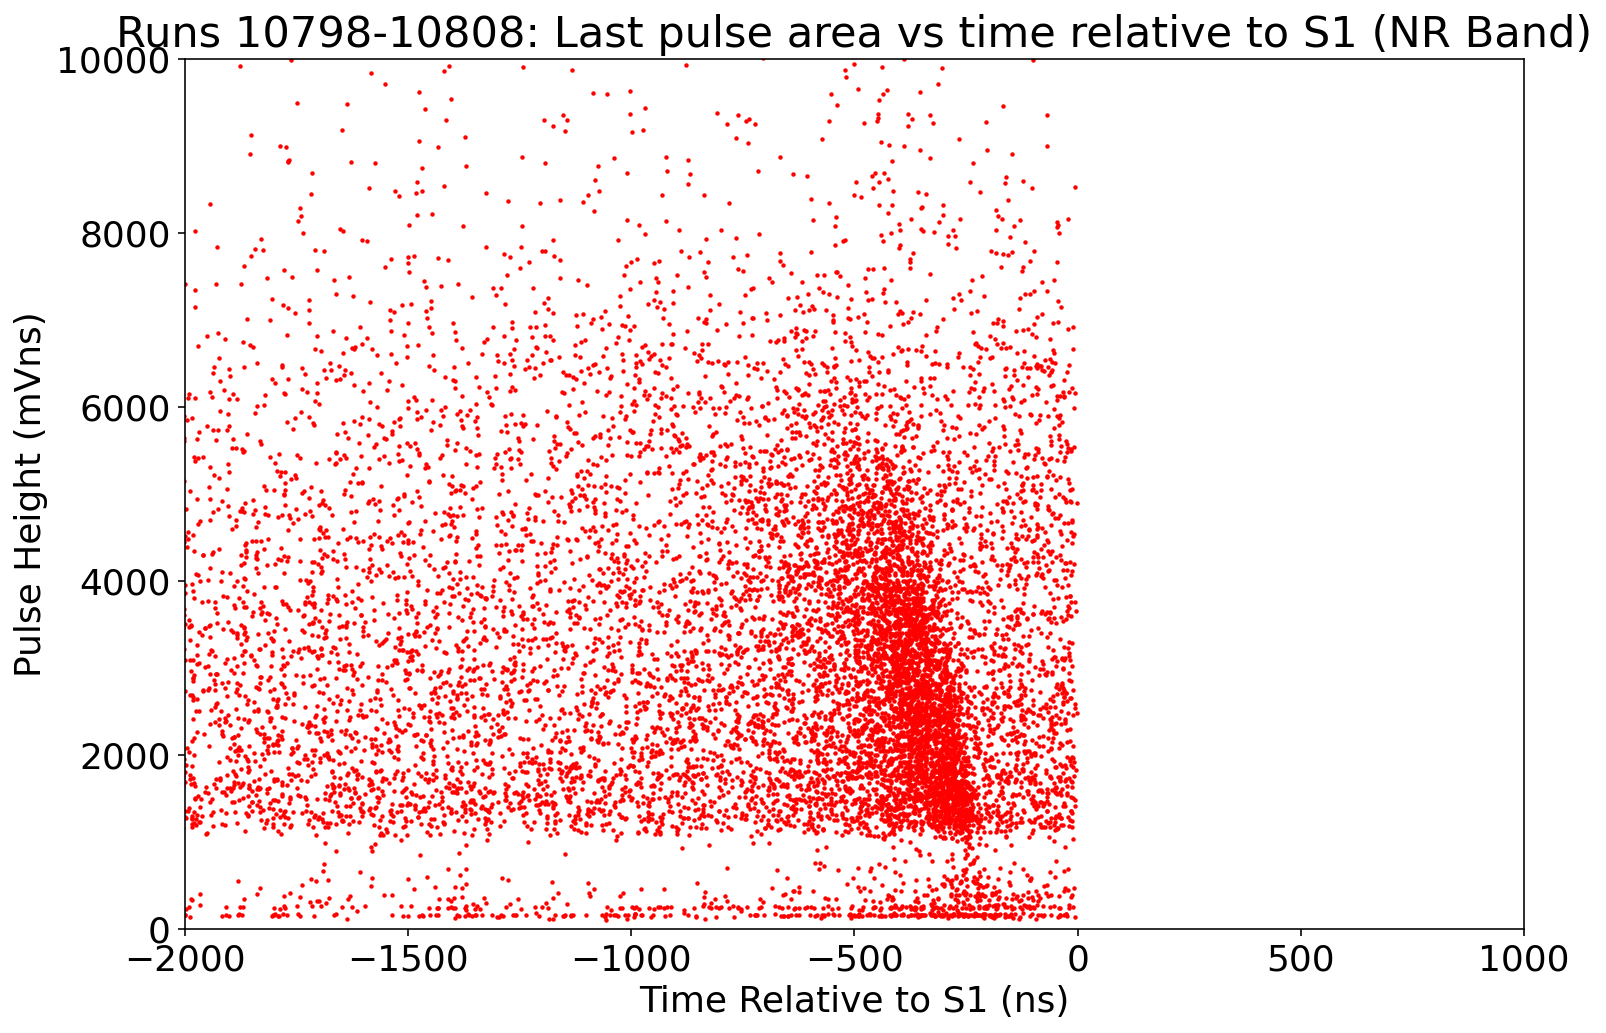

In [25]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 18}) 

pulse_size_array_last = np.array(pulse_size_array_last)
E_dep_cut_array = np.array(E_dep_cut_array)

pulse_size_last_cut = (pulse_size_array_last > 4000)
E_dep_cut = (E_dep_cut_array < 8)

pulse_times_array_last_fuzzy = pulse_times_array_last + np.random.normal(loc=0,scale=4,size=len(pulse_times_array_last))
plt.scatter(pulse_times_array_last_fuzzy, pulse_size_array_last, s=1.5, color='red')
plt.title("Runs 10798-10808: Last pulse area vs time relative to S1 (NR Band)")
plt.ylim(0, 10000)
plt.xlim(-2000, 1000)
plt.xlabel("Time Relative to S1 (ns)")
plt.ylabel("Pulse Height (mVns)")

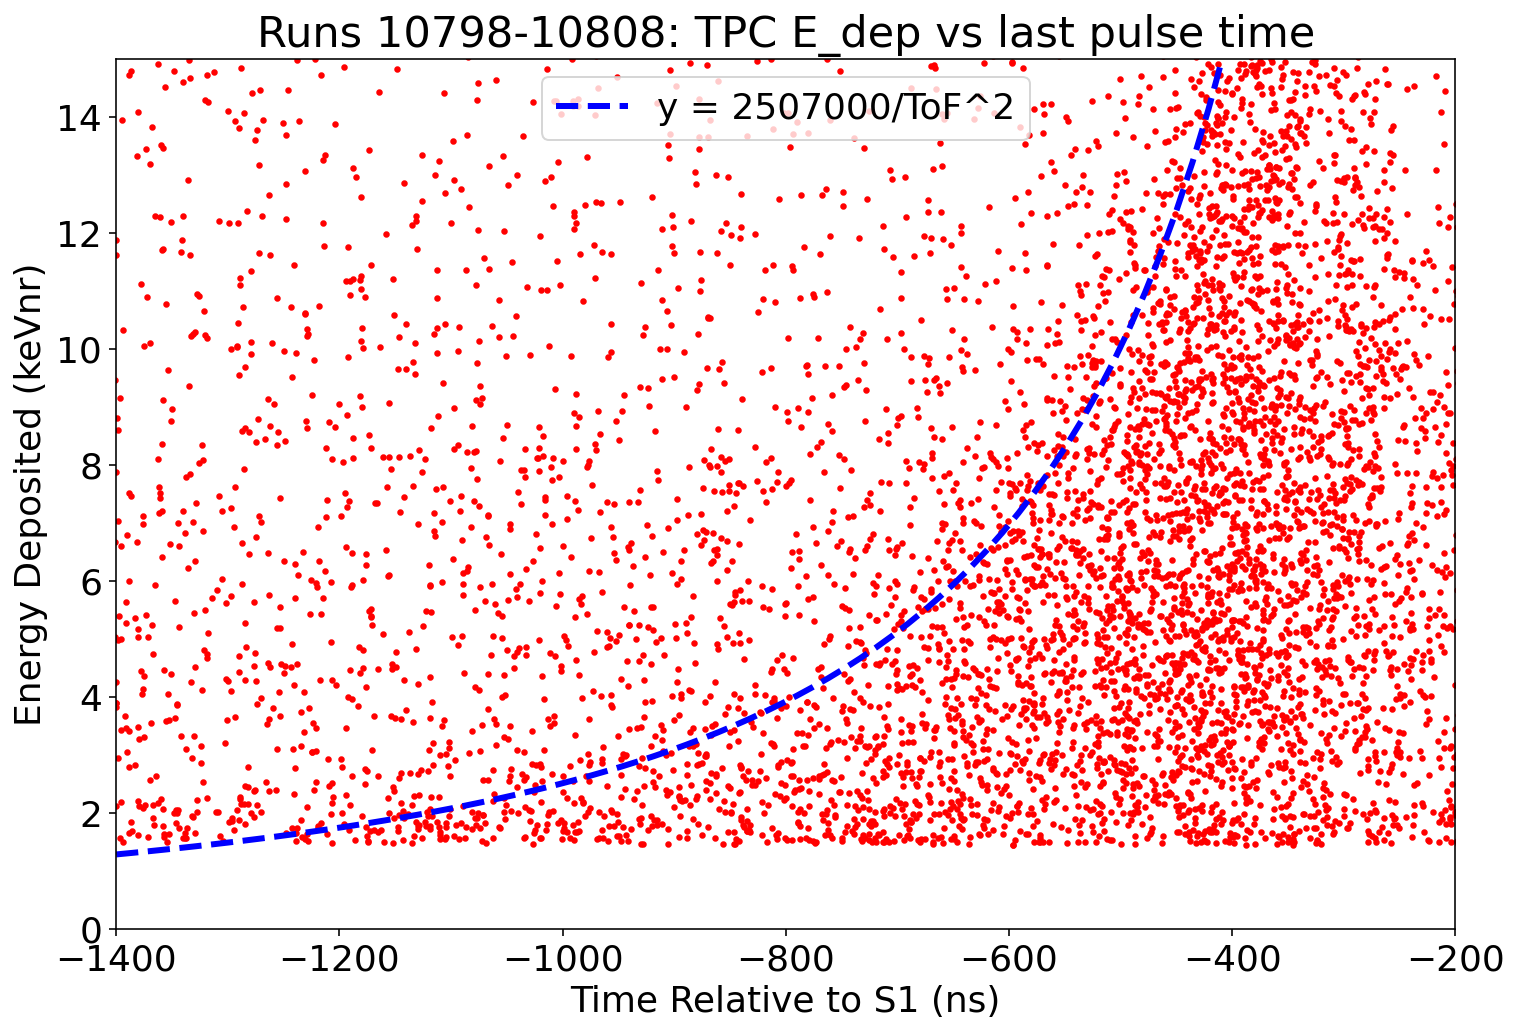

In [38]:
x_values = np.linspace(-1400, -10, 99)
y_values = 2507000/((x_values)**2)

E_dep_cut_array = np.array(E_dep_cut_array)

#[pulse_size_last_cut&E_dep_cut]

plt.figure(figsize=(12,8))
plt.scatter(pulse_times_array_last_fuzzy, E_dep_cut_array, s=5, color='red')
plt.plot(x_values, y_values, linestyle='dashed', color='blue', label='y = 2507000/ToF^2', linewidth=3)
plt.title("Runs 10798-10808: TPC E_dep vs last pulse time")
plt.ylim(0, 15)
plt.xlim(-1400, -200)
plt.xlabel("Time Relative to S1 (ns)")
plt.ylabel("Energy Deposited (keVnr)")
plt.legend(loc='upper center')
plt.show()

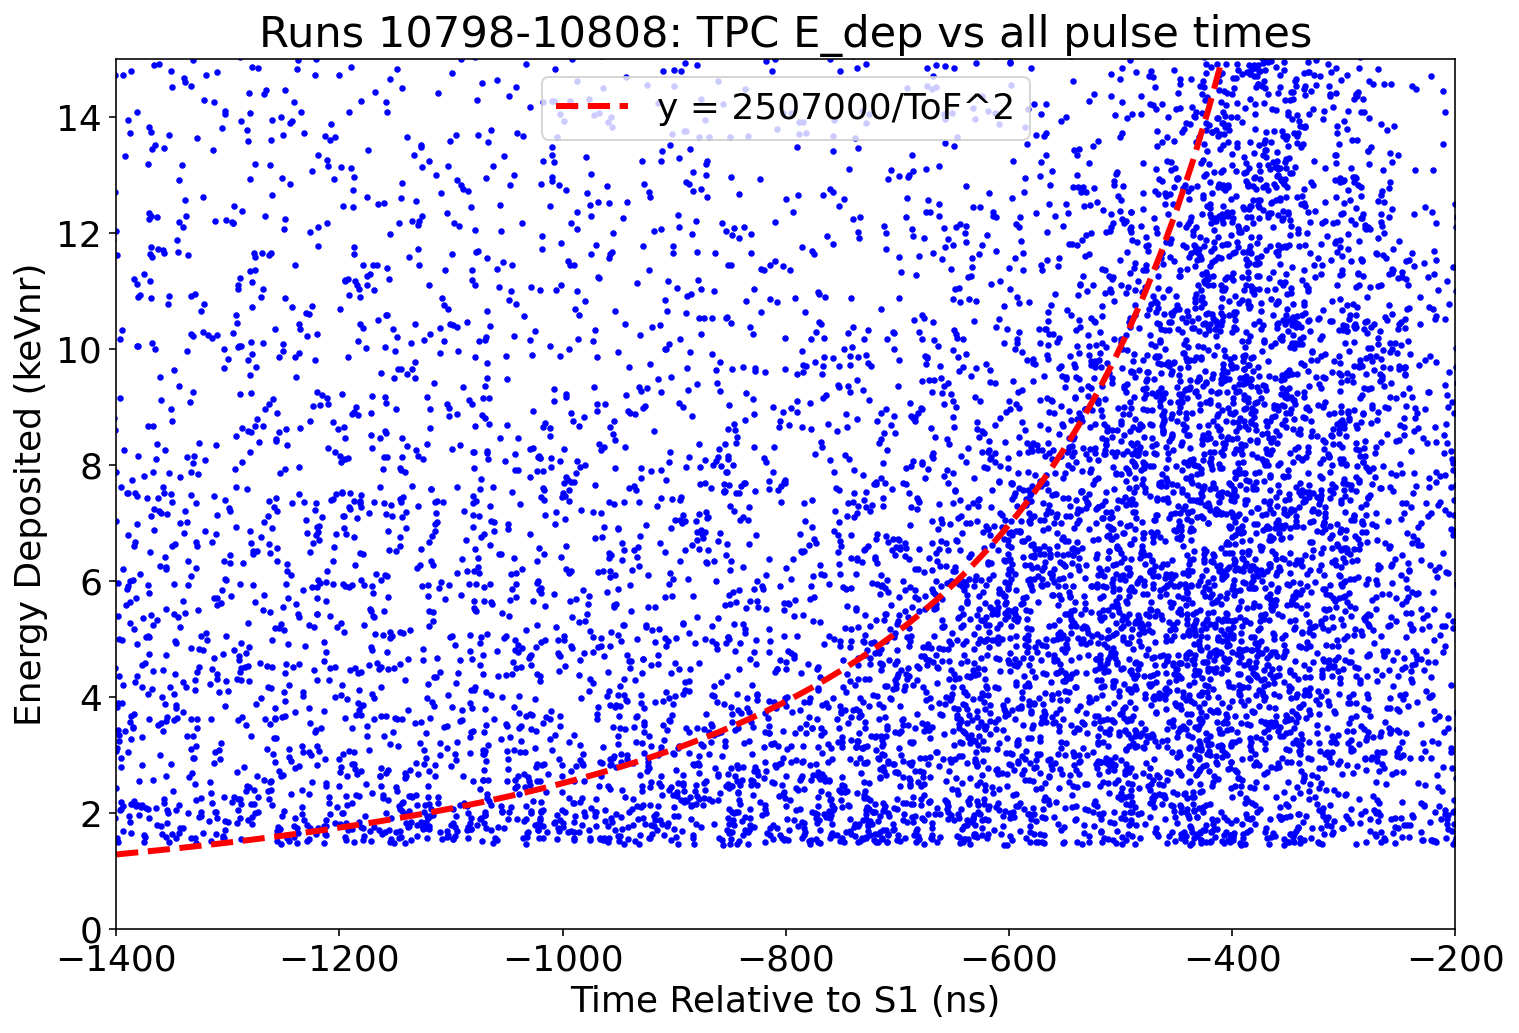

In [39]:
x_values = np.linspace(-1400, -10, 99)
y_values = 2507000/((x_values)**2)

E_dep_cut_array_all = np.array(E_dep_cut_array_all)
E_dep_cut = (E_dep_cut_array_all < 8)

pulse_size_array = np.array(pulse_size_array)
pulse_size_cut = (pulse_size_array > 4000)

#[pulse_size_cut&E_dep_cut]

plt.figure(figsize=(12,8))
plt.scatter(pulse_times_array_fuzzy, E_dep_cut_array_all, s=5, color='blue')
plt.plot(x_values, y_values, linestyle='dashed', color='red', label='y = 2507000/ToF^2', linewidth=3)
plt.title("Runs 10798-10808: TPC E_dep vs all pulse times")
plt.ylim(0, 15)
plt.xlim(-1400, -200)
plt.xlabel("Time Relative to S1 (ns)")
plt.ylabel("Energy Deposited (keVnr)")
plt.legend(loc='upper center')
plt.show()

30.0
0.2222222222222222


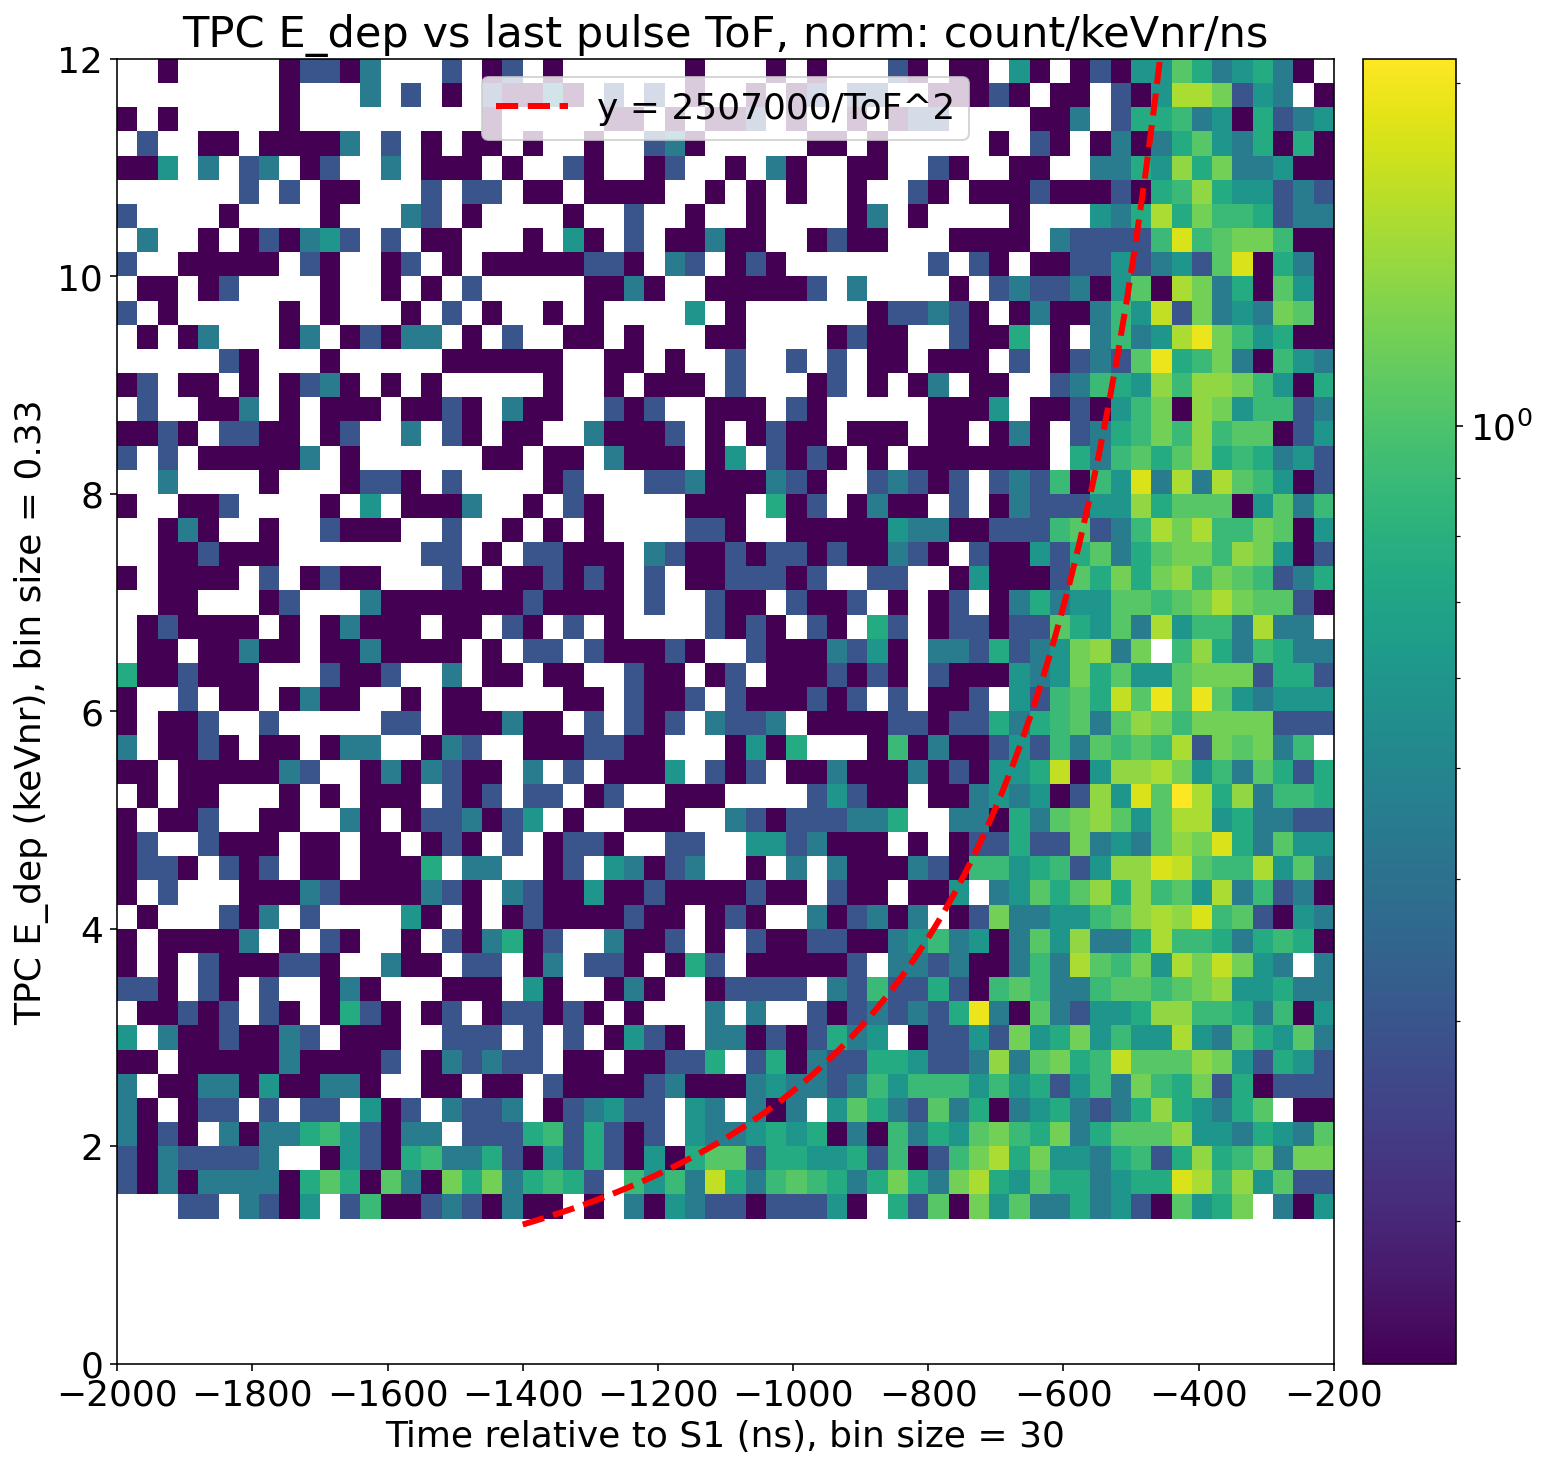

In [43]:
x_bins = 60
y_bins = 54
xlim = [-2000, -200]
ylim = [0, 12]

Edep_ToF_hist = bh.Histogram(bh.axis.Regular(x_bins, xlim[0], xlim[1]),bh.axis.Regular(y_bins, ylim[0], ylim[1]))
Edep_ToF_hist.fill(pulse_times_array_last_fuzzy, E_dep_cut_array)
x_values = np.linspace(-1400, -10, 99)
y_values = 2507000/((x_values)**2)

#Normalization
Edep_ToF_hist = Edep_ToF_hist/(((xlim[1]-xlim[0])/x_bins)*((ylim[1]-ylim[0])/y_bins))

print(((xlim[1]-xlim[0])/x_bins))
print(((ylim[1]-ylim[0])/y_bins))

fig = plt.figure(figsize=(12, 12))
plt.xlabel('Time relative to S1 (ns), bin size = 30')
plt.ylabel('TPC E_dep (keVnr), bin size = 0.33')
plt.title('TPC E_dep vs last pulse ToF, norm: count/keVnr/ns') 
mplhep.hist2dplot(Edep_ToF_hist, norm=LogNorm())
plt.plot(x_values,y_values,color='red', linestyle='dashed', lw=3, label='y = 2507000/ToF^2')
plt.legend(loc='upper center')
plt.show()

30.0
0.2
30.0
0.2


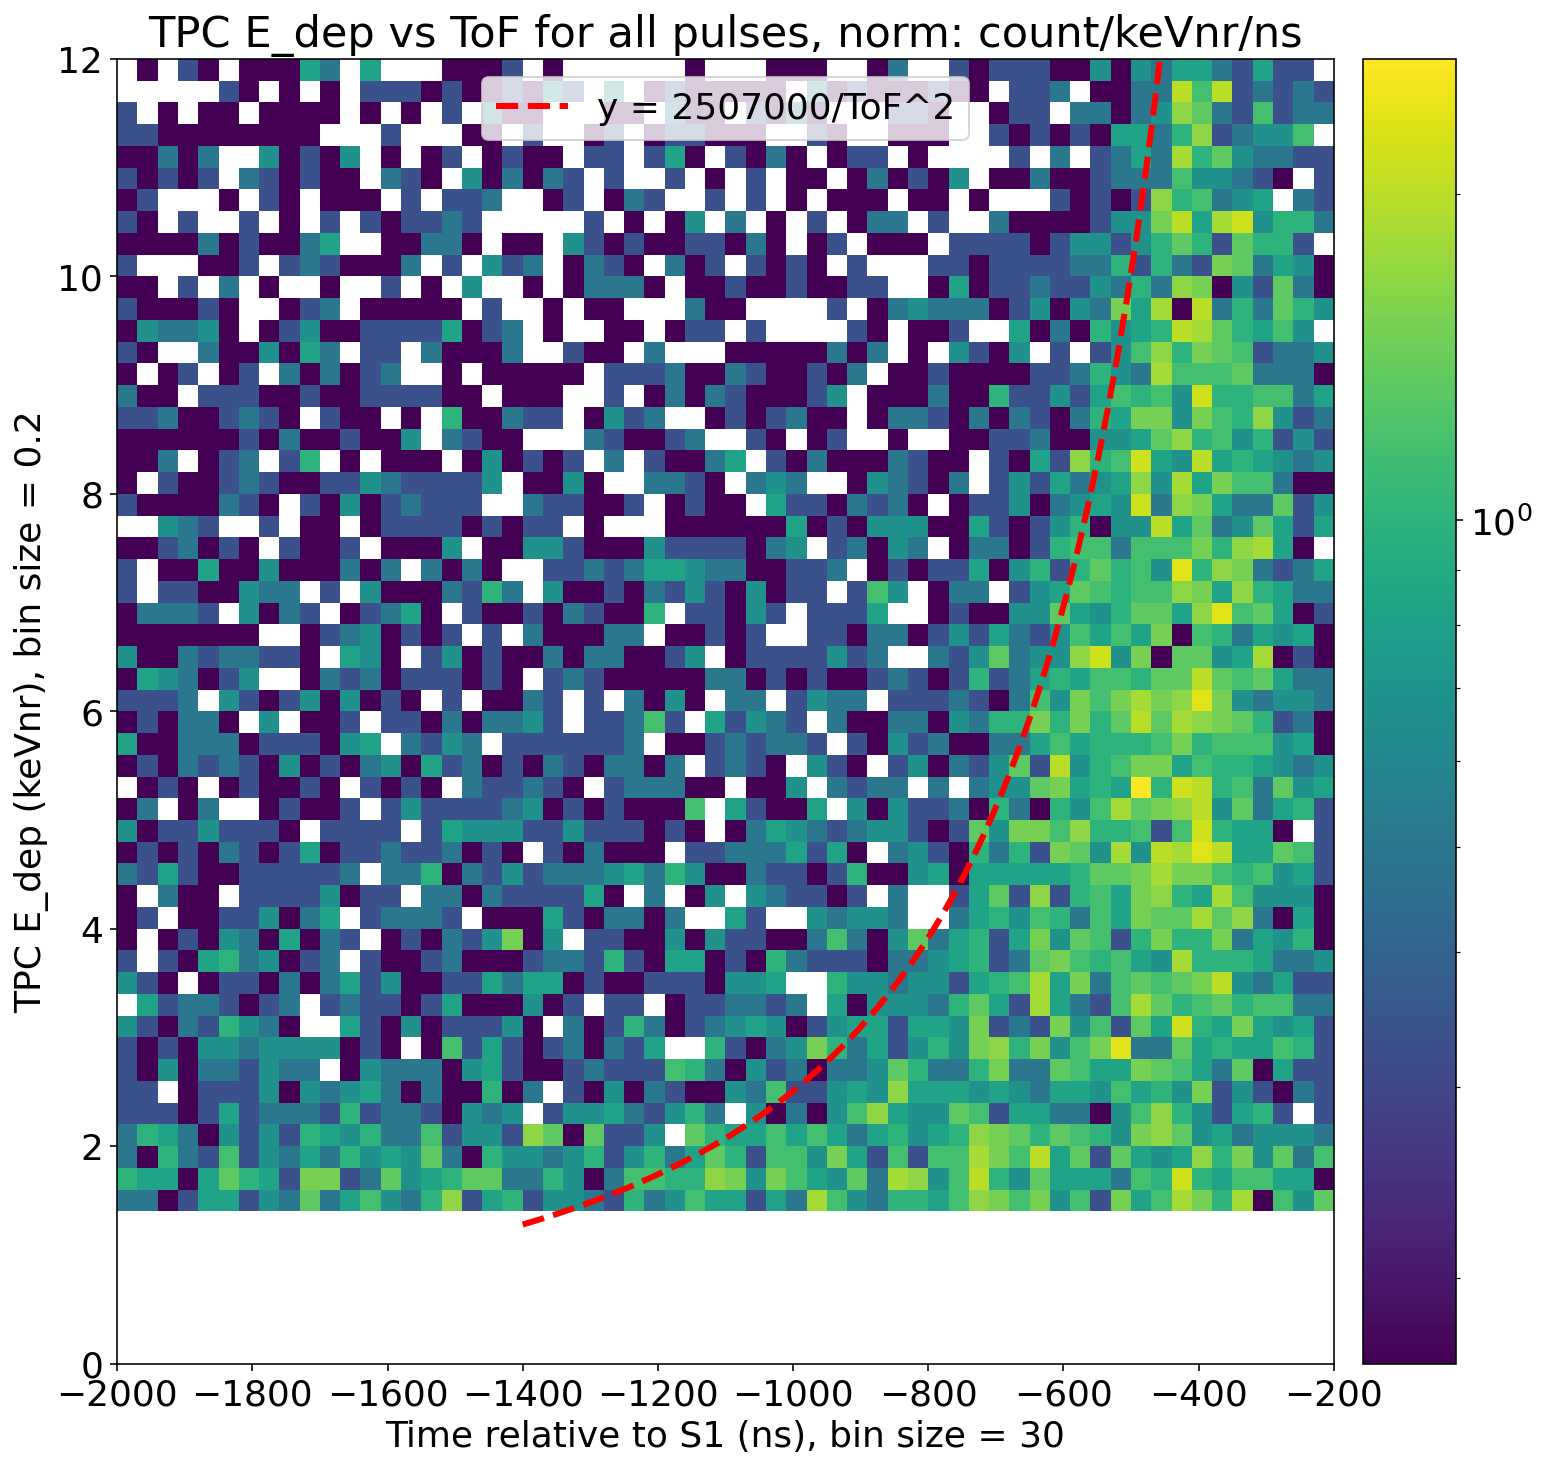

In [140]:
x_bins = 60
y_bins = 60
xlim = [-2000, -200]
ylim = [0, 12]

E_dep_cut_array_all = np.array(E_dep_cut_array_all)
E_dep_cut = (E_dep_cut_array_all < 8)

pulse_size_array = np.array(pulse_size_array)
pulse_size_cut = (pulse_size_array > 1)

Edep_ToF_hist = bh.Histogram(bh.axis.Regular(x_bins, xlim[0], xlim[1]),bh.axis.Regular(y_bins, ylim[0], ylim[1]))
Edep_ToF_hist.fill(pulse_times_array_fuzzy[pulse_size_cut], E_dep_cut_array_all[pulse_size_cut])
x_values = np.linspace(-1400, -10, 99)
y_values = 2507000/((x_values)**2)

#Normalization
Edep_ToF_hist = Edep_ToF_hist/(((xlim[1]-xlim[0])/x_bins)*((ylim[1]-ylim[0])/y_bins))

xsize = ((xlim[1]-xlim[0])/x_bins)
ysize = ((ylim[1]-ylim[0])/y_bins)

print(((xlim[1]-xlim[0])/x_bins))
print(((ylim[1]-ylim[0])/y_bins))
print(xsize)
print(ysize)

fig = plt.figure(figsize=(12, 12))
plt.xlabel('Time relative to S1 (ns), bin size = 30')
plt.ylabel('TPC E_dep (keVnr), bin size = 0.2')
plt.title('TPC E_dep vs ToF for all pulses, norm: count/keVnr/ns') 
mplhep.hist2dplot(Edep_ToF_hist, norm=LogNorm())
plt.plot(x_values,y_values,color='red', linestyle='dashed', lw=3, label='y = 2507000/ToF^2')
plt.legend(loc='upper center')
plt.show()

122649
1.8405405734253628


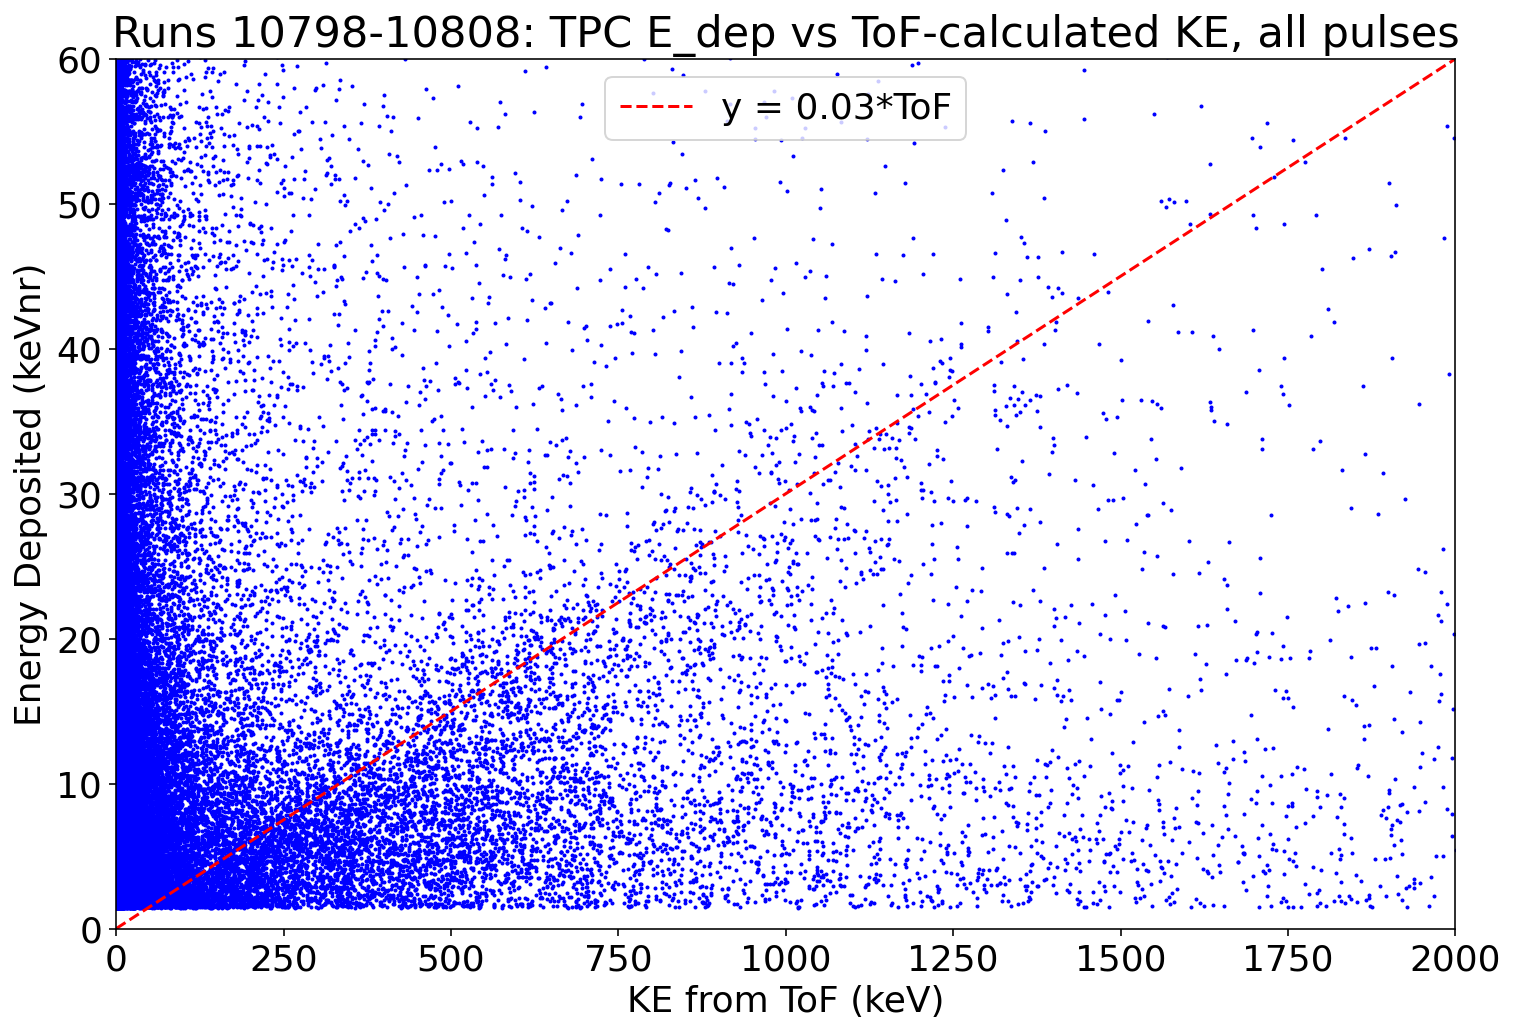

In [147]:
energy_from_ToF = []
for j in range(len(pulse_times_array_fuzzy)):
    energy_from_ToF.append((0.5*940000000*(1/(9*(10**16)))*(4/((-pulse_times_array_fuzzy[j])*10**(-9)))**2)/1000)

energy_from_ToF = np.array(energy_from_ToF)
    
x_values = np.linspace(0, 2000, 10)
y_values = 0.03*x_values

print(len(energy_from_ToF))
print(energy_from_ToF[2])
plt.figure(figsize=(12,8))
plt.scatter(energy_from_ToF, E_dep_cut_array_all, s=1, color='blue')
plt.plot(x_values, y_values, linestyle='dashed', color='red', label='y = 0.03*ToF')
plt.title("Runs 10798-10808: TPC E_dep vs ToF-calculated KE, all pulses")
plt.ylim(0,60)
plt.xlim(0, 2000)
plt.xlabel("KE from ToF (keV)")
plt.ylabel("Energy Deposited (keVnr)")
plt.legend(loc='upper center')
plt.show()

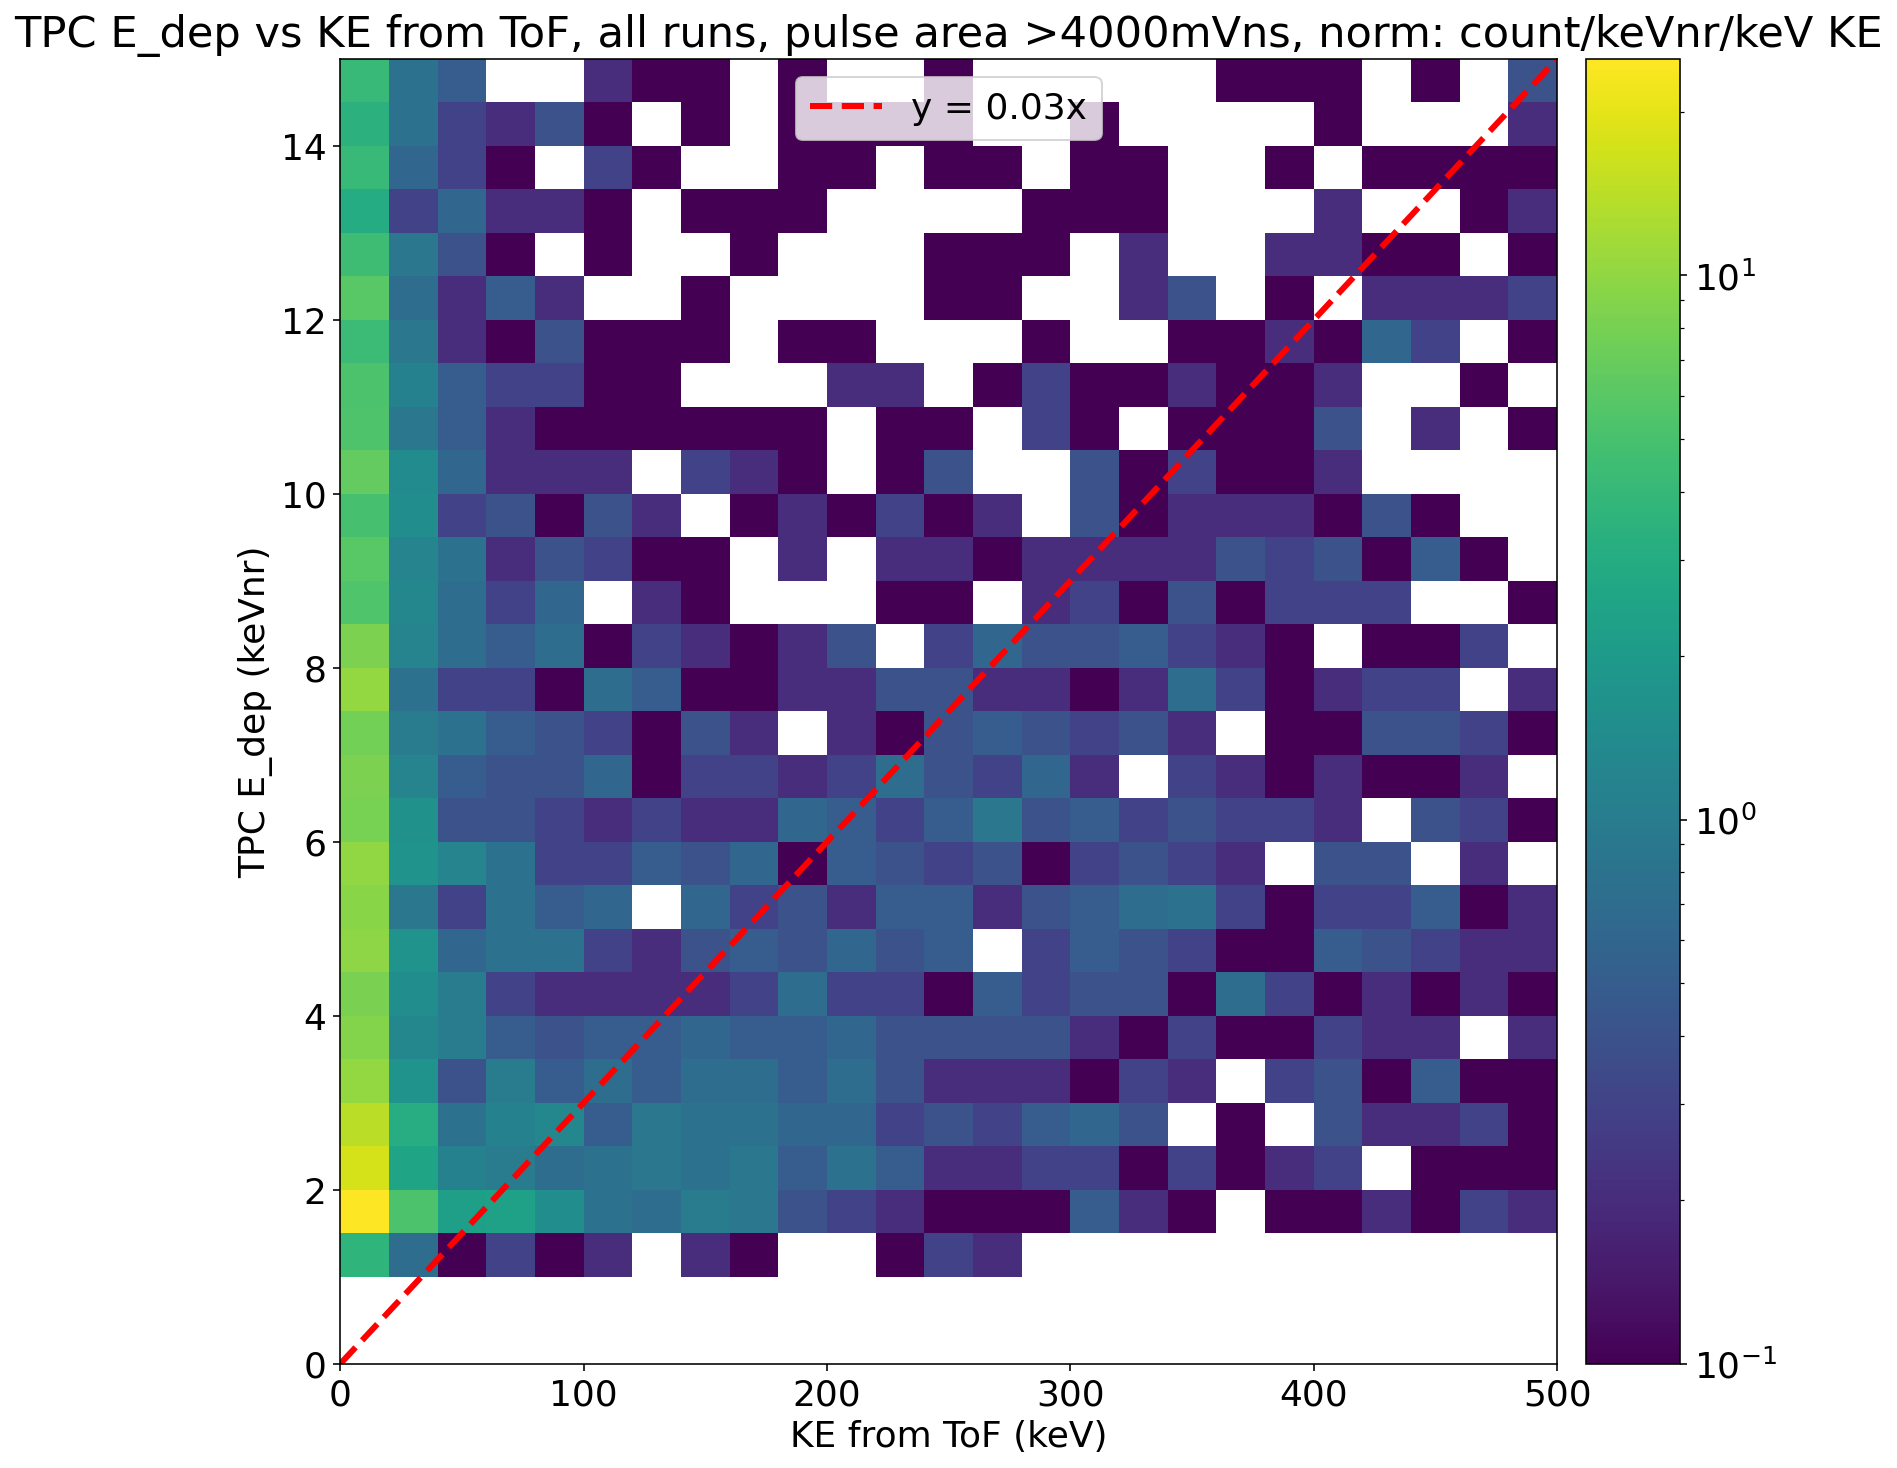

In [84]:
x_bins = 25
y_bins = 30
xlim = [0, 500]
ylim = [0, 15]

Edep_KE_hist = bh.Histogram(bh.axis.Regular(x_bins, xlim[0], xlim[1]),bh.axis.Regular(y_bins, ylim[0], ylim[1]))
Edep_KE_hist.fill(energy_from_ToF[pulse_size_last_cut], E_dep_cut_array[pulse_size_last_cut])
x_values = np.linspace(0, 1000, 100)
y_values = 0.03*(x_values)

#Normalization
Edep_KE_hist = Edep_KE_hist/(((xlim[1]-xlim[0])/x_bins)*((ylim[1]-ylim[0])/y_bins))

fig = plt.figure(figsize=(12, 12))
plt.xlabel('KE from ToF (keV)')
plt.ylabel('TPC E_dep (keVnr)')
plt.title('TPC E_dep vs KE from ToF, all runs, pulse area >4000mVns, norm: count/keVnr/keV KE') 
mplhep.hist2dplot(Edep_KE_hist, norm=LogNorm())
plt.plot(x_values,y_values,color='red', linestyle='dashed', lw=3, label='y = 0.03x')
plt.legend(loc='upper center')
plt.show()

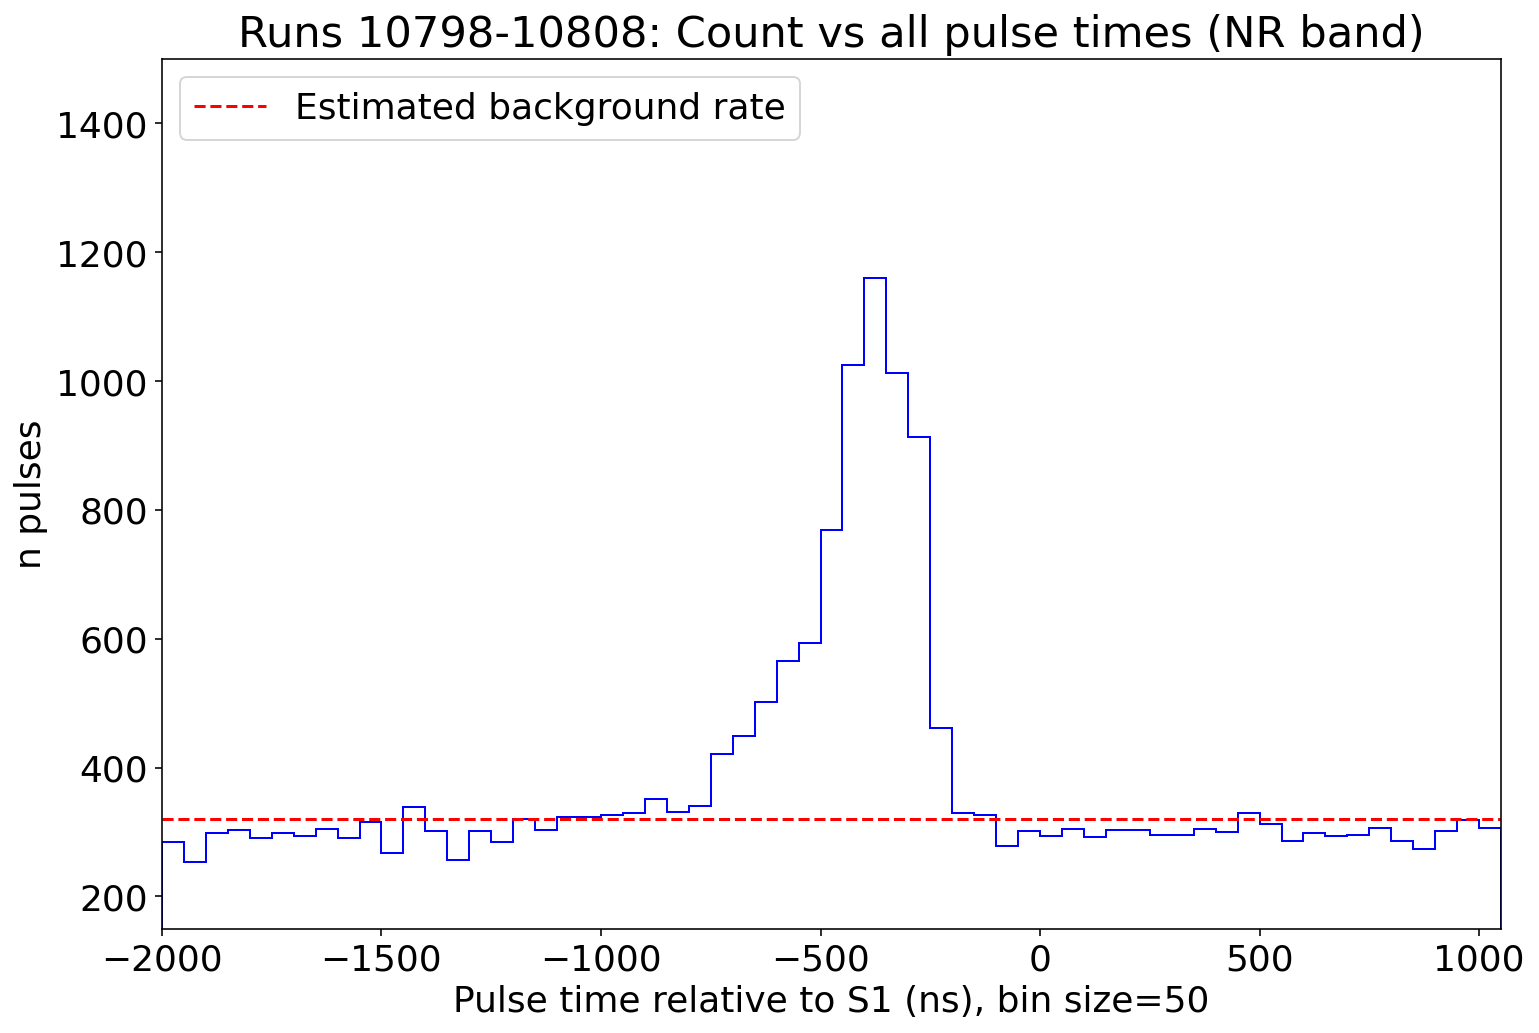

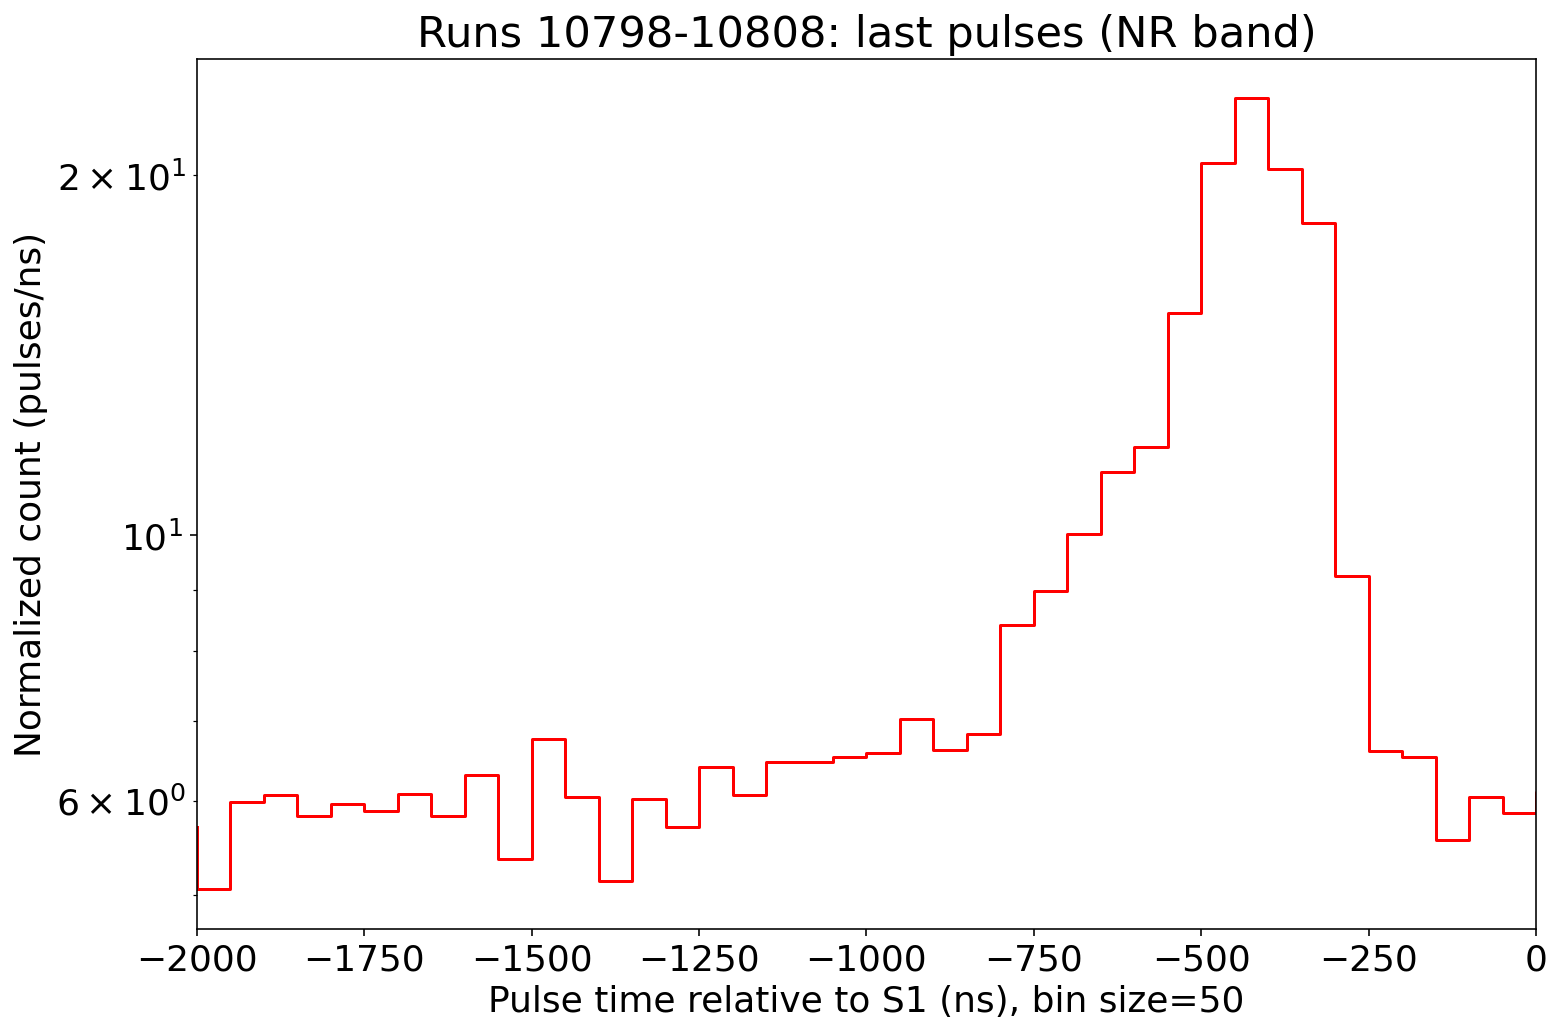

#Events with last pulse in Href SS region (> -1650 ns and < -650 ns):  6979.0
#Total pulses:  23034.0


In [53]:
plt.figure(figsize=(12,8))
pulse_size_array_last = np.array(pulse_size_array_last)
xlim = [-2000,1050]
binsize = 50
bins = int((xlim[1]-xlim[0])/binsize)
#pulse_area_cut = (pulse_size_array > 6000)
pulse_times_afl = pulse_times_array_fuzzy[(np.array(pulse_times_array_fuzzy) > xlim[0])&(np.array(pulse_times_array_fuzzy) < xlim[1])]
counts, bins, bars = plt.hist(pulse_times_afl, histtype='step', bins=bins, color='blue')
plt.xlim(-2000, 1050)
plt.title("Runs 10798-10808: Count vs all pulse times (NR band)")
plt.xlabel("Pulse time relative to S1 (ns), bin size=50")
plt.ylabel("n pulses")
plt.ylim(150,1500)
plt.axhline(y=320, color='red', linestyle='dashed', label='Estimated background rate')
plt.legend(loc='upper left')
plt.show()

normalized_counts = counts/binsize
plt.figure(figsize=(12,8))
plt.step(x=bins[:-1], y=normalized_counts, color='red')
plt.xlim(-2000, 0)
plt.title("Runs 10798-10808: last pulses (NR band)")
plt.xlabel("Pulse time relative to S1 (ns), bin size=50")
plt.ylabel("Normalized count (pulses/ns)")
plt.yscale('log')
plt.show()

counter_coin = 0
counter_all = 0
for i in range(len(bins) - 1):
    counter_all = counter_all + counts[i]
    if(bins[i] > -1650 and bins[i] < -650):
        counter_coin = counter_coin + counts[i]
print("#Events with last pulse in Href SS region (> -1650 ns and < -650 ns): ", counter_coin)
print("#Total pulses: ", counter_all)

        

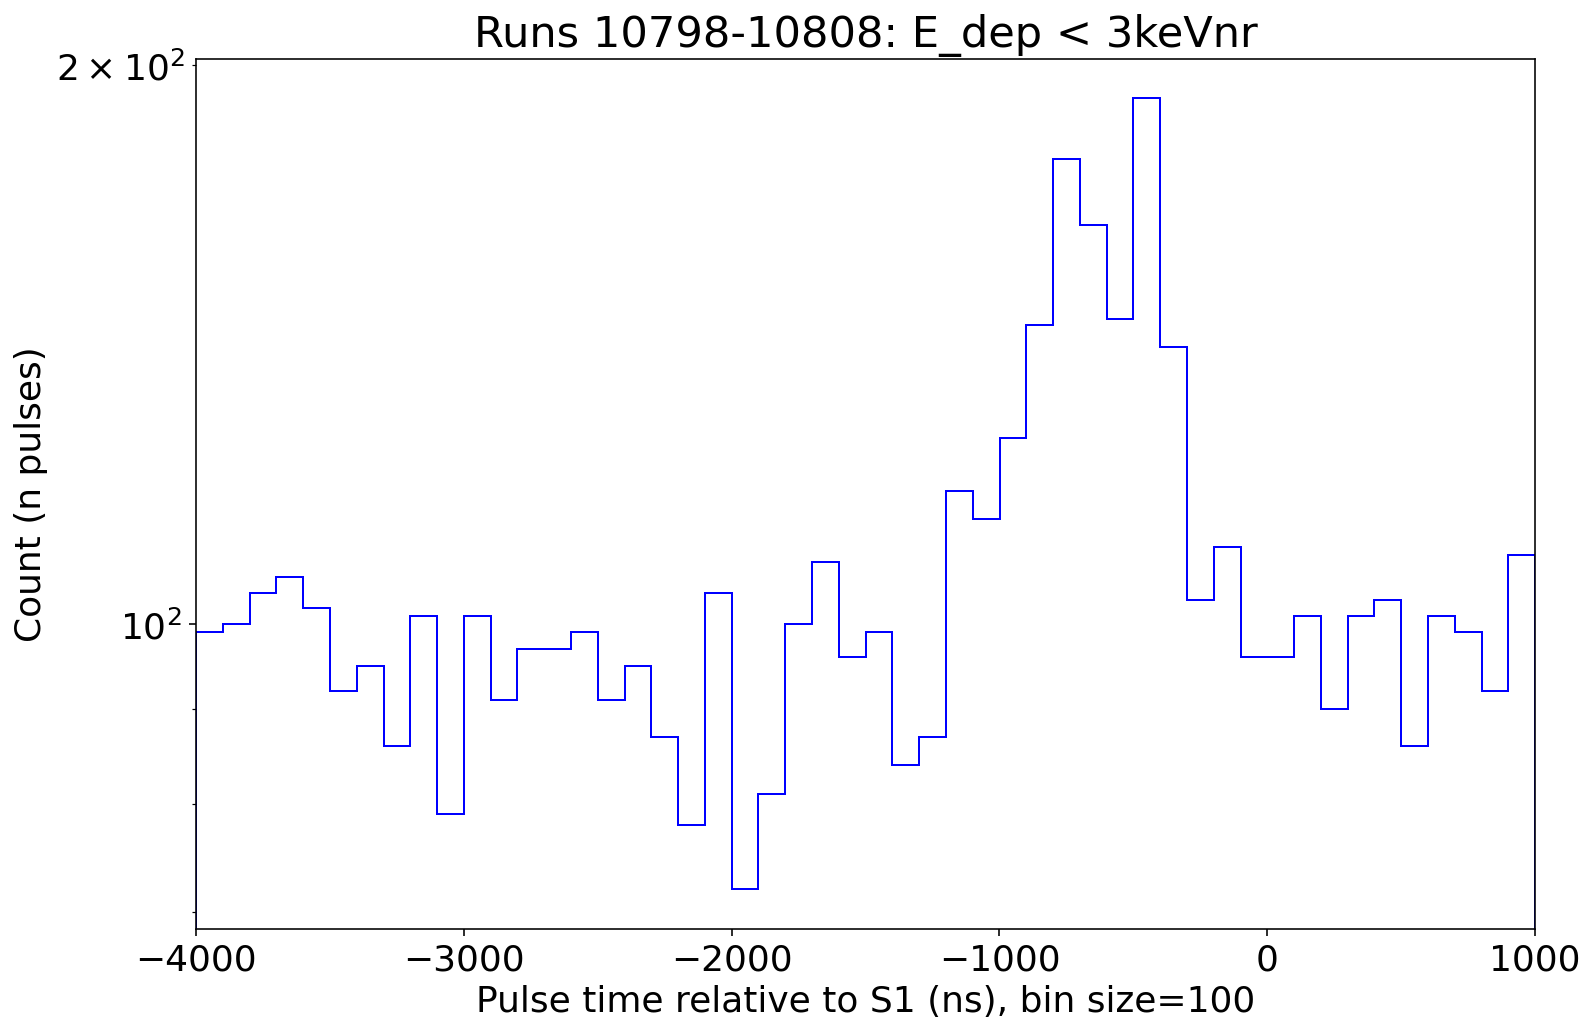

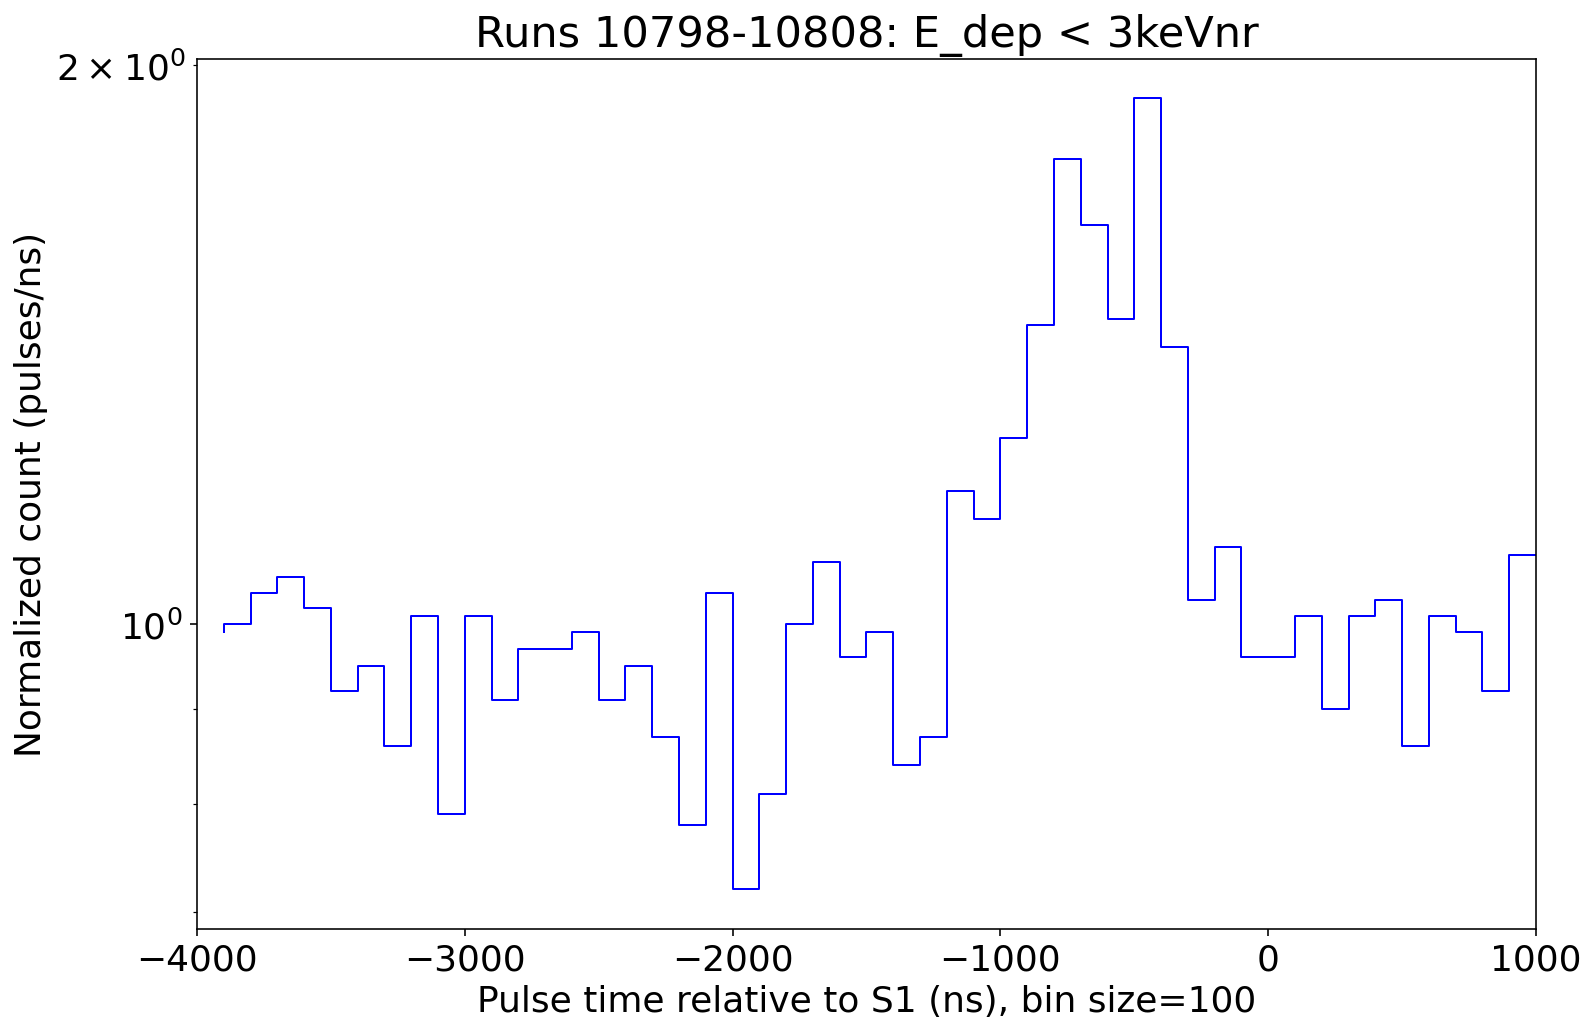

#Events with last pulse in Href SS region (> -1650 ns and < -650 ns):  1211.0
#Total pulses:  5242.0


In [136]:
plt.figure(figsize=(12,8))

xlim = [-4000,1000]
binsize = 100
n_bins = int((xlim[1]-xlim[0])/binsize)
#pulse_size_array_last = np.array(pulse_size_array_last)
#E_dep_cut_array = np.array(E_dep_cut_array)

pulse_size_array = np.array(pulse_size_array)
E_dep_cut_array_all = np.array(E_dep_cut_array_all)

#pulse_size_last_cut = (pulse_size_array_last > 1)
#E_dep_cut = (E_dep_cut_array < 8)

pulse_size_cut = (pulse_size_array > 1)
E_dep_cut = (E_dep_cut_array_all < 3)

pulse_times_cut = ((np.array(pulse_times_array_fuzzy) > (xlim[0]))&(np.array(pulse_times_array_fuzzy) < xlim[1]))

counts, bins, bars = plt.hist(pulse_times_array_fuzzy[E_dep_cut&pulse_size_cut&pulse_times_cut], histtype='step', bins=n_bins, color='blue')
plt.xlim(xlim[0], xlim[1])
plt.yscale('log')
plt.title("Runs 10798-10808: E_dep < 3keVnr")
plt.xlabel("Pulse time relative to S1 (ns), bin size=100")
plt.ylabel("Count (n pulses)")
plt.show()

normalized_counts = counts/binsize
plt.figure(figsize=(12,8))
plt.step(x=(bins[:-1] + binsize), y=normalized_counts, color='blue', linewidth=1)
plt.xlim(xlim[0], xlim[1])
plt.title("Runs 10798-10808: E_dep < 3keVnr")
plt.xlabel("Pulse time relative to S1 (ns), bin size=100")
plt.ylabel("Normalized count (pulses/ns)")
plt.yscale('log')
plt.show()

counter_coin = 0
counter_all = 0
for i in range(len(bins) - 1):
    counter_all = counter_all + counts[i]
    if(bins[i] > -1650 and bins[i] < -650):
        counter_coin = counter_coin + counts[i]
print("#Events with last pulse in Href SS region (> -1650 ns and < -650 ns): ", counter_coin)
print("#Total pulses: ", counter_all)

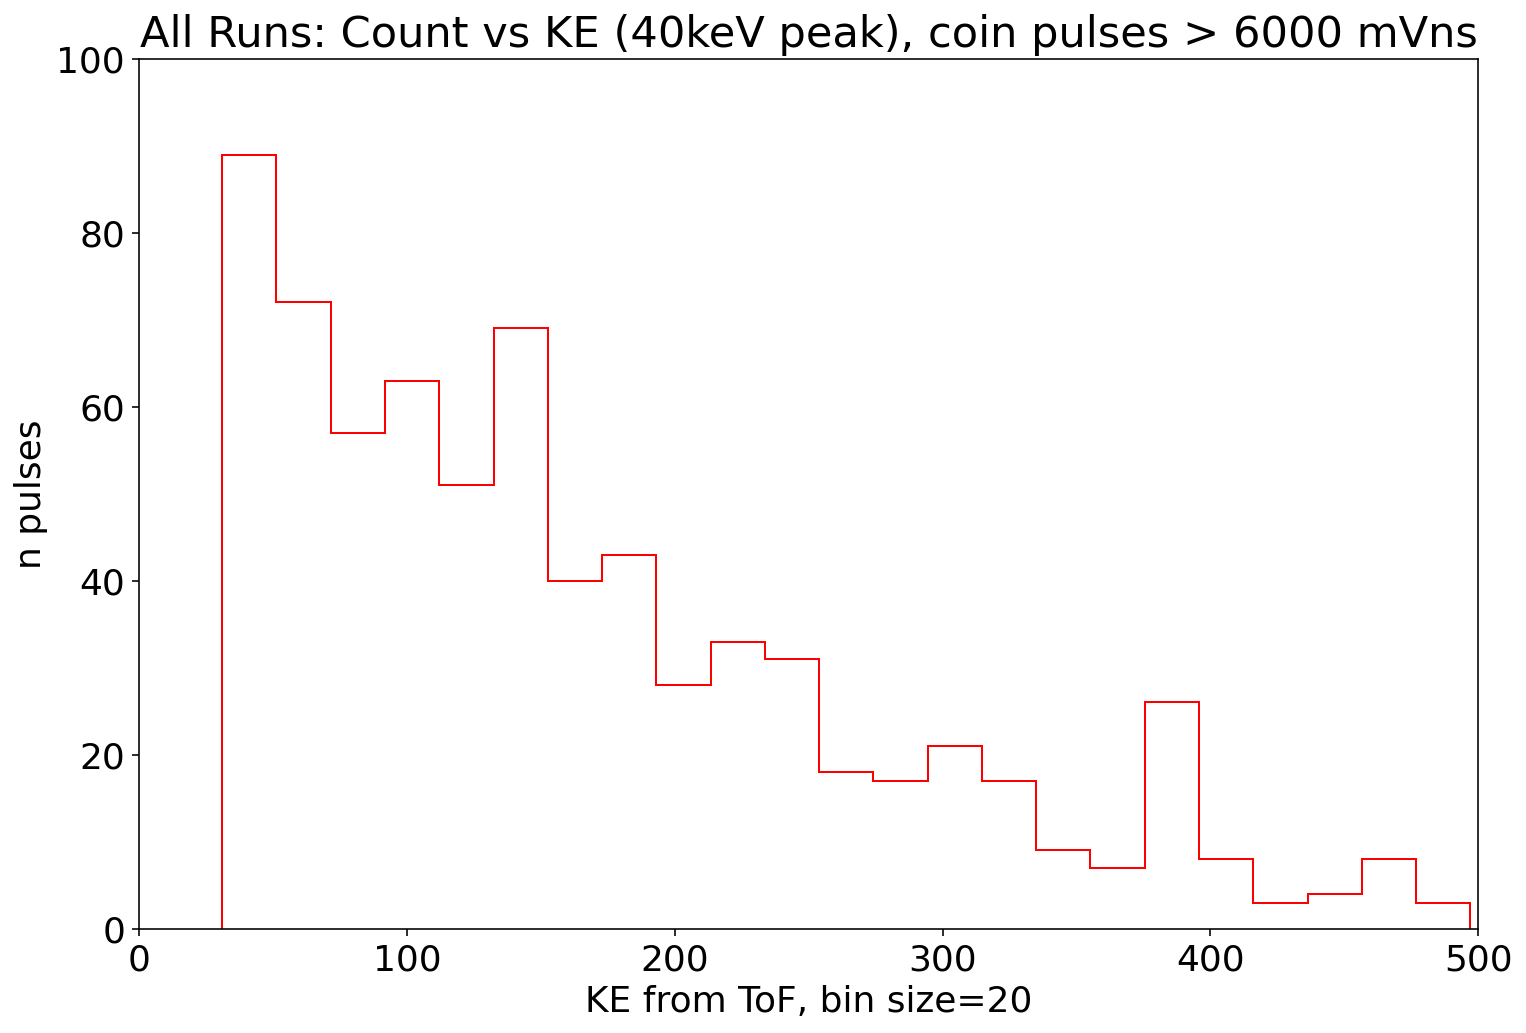

In [154]:
energy_from_ToF = []
for j in range(len(pulse_times_array_last)):
    energy_from_ToF.append((0.5*940000000*(1/(9*(10**16)))*(4/((-pulse_times_array_last[j])*10**(-9)))**2)/1000)

plt.rcParams.update({'font.size': 18})  
pulse_times_array_last = np.array(pulse_times_array_last)
pulse_size_array_last = np.array(pulse_size_array_last)
energy_from_ToF_array = np.array(energy_from_ToF)
timing_cut = (pulse_times_array_last > -1650)&(pulse_times_array_last < -150)
energy_bound_cut = (energy_from_ToF_array < 500)
#area_cut = (pulse_size_array_last > 6000)
energy_from_ToF_coin = energy_from_ToF_array[timing_cut&pulse_area_cut&energy_bound_cut]
#energy_from_ToF_coin = energy_from_ToF_array
plt.figure(figsize=(12,8))
plt.hist(energy_from_ToF_coin, histtype='step', bins=23, color='red')
#counts, bins, bars = plt.hist(energy_from_ToF_array, histtype='step', bins=166, color='red')
plt.xlim(0, 500)
plt.ylim(0, 100)
plt.title("All Runs: Count vs KE (40keV peak), coin pulses > 6000 mVns")
plt.xlabel("KE from ToF, bin size=20")
plt.ylabel("n pulses")
plt.show()


(0.0, 500.0)

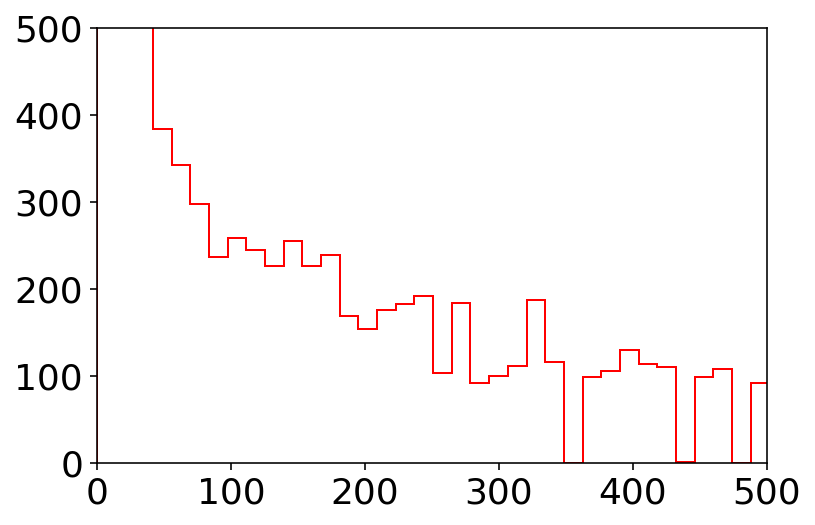

In [133]:
plt.hist(energy_from_ToF_array[energy_bound_cut], histtype='step', bins=166, color='red')
plt.ylim(0, 500)
plt.xlim(0, 500)

In [91]:
#Now, do the analysis in parallel with all files from a particular run to try to find a pattern
energy_hist_regular = bh.Histogram(bh.axis.Regular(100, 0, 100),bh.axis.Regular(100, 0, 4))
energy_hist_adaptive = bh.Histogram(bh.axis.Regular(100, 0, 100),bh.axis.Regular(100, 0, 4))
E_dep_hist = bh.Histogram(bh.axis.Regular(100,0,6))
s1_s2_hist = bh.Histogram(bh.axis.Regular(50, 0, 4),bh.axis.Regular(50, 1.5, 3.5))

a = 11
b = 1.1
#These next values are for 9kV
#g1 = 0.1080
#g2 = 58.18

g1 = 0.1125
g2 = 37.38

coin_window_ns = [600, 1650]
href_mVns_limit = [6000, 8500]

#Hotspot positions: (-25, 8) and (0, 9) or so, with radius of 5cm or so 


rpos_lim = 67.5
rpos_lim_lower = 50
drift_time_lim = [10,120]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 15
b_lb = -15

s1_s2_cut_pass = 0
s1_s2_ss_cut_pass = 0
all_cut_pass = 0
total = 0

E_dep_list = []
E_dep_list_final = []
ToF_list_final = []
s1_list_final = []
logs2_list_final = []
xpos_list_final = []
ypos_list_final = []
candidate_pulse_time_diff_final = []

num_candidate_pulses = np.zeros(50)
good_event_ids = []

for i in range(len(dd_files)):
    
    if (i == 0):
        continue
    if (i%10 == 0):
        print("Loading file number ",i)
    
    file = uproot.open(dd_files[i])
    peakTime = file['External']['pmtDDReflector./pmtDDReflector.peakTime_ns'].array(library='np')
    pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
    pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
    #pulseEndTime = file['External']['pmtDDReflector./pmtDDReflector.pulseEndTime_ns'].array(library='np')
    limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')
    s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
    s2_pulse_id = file['Scatters']['ss./ss.s2PulseID'].array(library='np')

    #s1_area = file['Scatters']['ss./ss.s1Area_phd'].array(library='np')
    #s2_area = file['Scatters']['ss./ss.s2Area_phd'].array(library='np')
    s1_corrected_area = file['Scatters']['ss./ss.correctedS1Area_phd'].array(library='np')
    s2_corrected_area = file['Scatters']['ss./ss.correctedS2Area_phd'].array(library='np')
    ss_number = file['Scatters']['ss./ss.nSingleScatters'].array(library='np')

    pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')
    pulseAreaTPC = file['Events']['pulsesTPC./pulsesTPC.pulseArea_phd'].array(library='np')

    s1_start_times = []
    s2_start_times = []
    s1Area = []
    s2Area = []
    
    good_event_id = np.array(list(range(0,1250)))

    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    rpos = np.sqrt(xpos**2 + ypos**2)
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000

    rpos_cut = (rpos < rpos_lim) & (rpos > rpos_lim_lower) & (xpos < 0)
    y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])

    #Find S1,S2 start times and areas for each recorded event

    for j in range(len(s1_pulse_id)):
        s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]])
        #s1Area.append(pulseAreaTPC[j][s1_pulse_id[j]])
        s2_start_times.append(pulseStartTimeTPC[j][s2_pulse_id[j]])
        #s2Area.append(pulseAreaTPC[j][s2_pulse_id[j]])

    s1_start_times = np.array(s1_start_times)
    s2_start_times = np.array(s2_start_times)
    #s1Area = np.array(s1Area)
    #s2Area = np.array(s2Area)

    #s1 and s2 area cuts
    s1_area_cut = (s1_corrected_area > 60) & (s1_corrected_area < 110)
    s2_area_cut = (np.log10(s2_corrected_area) > 3.7) & (np.log10(s2_corrected_area) < 4)
    
    ss_cut = (ss_number > 0)
    #candidate_s1_cut = (evt_arrays['pulsesTPC.s1Probability']==1) | (evt_arrays['pulsesTPC.otherProbability']==1)
    s1_s2_basic_timing_cut = (s2_start_times - s1_start_times > 0)
    
    all_cuts = s1_area_cut&s2_area_cut&ss_cut&rpos_cut&y_cut&z_cut&s1_s2_basic_timing_cut
    #all_cuts = s1_area_cut&s2_area_cut
    s1_s2_cut_pass += len(xpos[s1_area_cut&s2_area_cut])
    s1_s2_ss_cut_pass += len(xpos[s1_area_cut&s2_area_cut&ss_cut])
    all_cut_pass += len(xpos[all_cuts])

    total += len(xpos)
    
    #s1Area_final = s1Area[all_cuts]
    #s2Area_final = s2Area[all_cuts]
    
    #Calculate energy deposited into LXe
    E_dep = (((s1_corrected_area/g1)+(s2_corrected_area/g2))/11)**(1/1.1)
    #print(E_dep[all_cuts][0:5])
    
    #Warning: this is only an estimate of energy deposited! Need to incorporate uncertainty as well
    for j in range(len(E_dep[all_cuts])):
        E_dep_list.append(E_dep[all_cuts][j])

    #Search for >5000 mVns signals within 10 us of s1 signal time
    #multiple_candidate = 0
    #single_candidate = 0
    #no_candidate = 0
    pulseStartTime_cuts = pulseStartTime[all_cuts]
    pulseAreaExt_cuts = pulseAreaExt[all_cuts]
    #print(len(pulseAreaExt_cuts))
    #print(len(pulseAreaExt))
    
    single_pulse_cut = []
    candidate_pulse_sizes = []
    candidate_pulse_time_diff = []
    for j in range(len(pulseStartTime)):
        if (all_cuts[j] == True):
            signal_size_cut = (pulseAreaExt[j] > href_mVns_limit[0]) & (pulseAreaExt[j] < href_mVns_limit[1])
            start_time_cut = ((s1_start_times[j] - pulseStartTime[j] + 300) < coin_window_ns[1]) & ((s1_start_times[j] - pulseStartTime[j] + 300) > coin_window_ns[0])
            candidate_pulses = pulseAreaExt[j][signal_size_cut&start_time_cut]
            temp = s1_start_times[j] - pulseStartTime[j] + 300
            candidate_pulse_timing = temp[signal_size_cut&start_time_cut]
            if (len(candidate_pulses) < 50):
                num_candidate_pulses[len(candidate_pulses)] += 1
            if (len(candidate_pulses) == 1):
                single_pulse_cut.append(True)
                candidate_pulse_sizes.append(candidate_pulses[0])
                candidate_pulse_time_diff.append(candidate_pulse_timing[0])
                #print(j)
            else:
                single_pulse_cut.append(False)
                candidate_pulse_sizes.append(0)
                candidate_pulse_time_diff.append(0)
        else:
            single_pulse_cut.append(False)
            candidate_pulse_sizes.append(0)
            candidate_pulse_time_diff.append(0)
    
    all_cuts_final = all_cuts&single_pulse_cut  
    try:
        good_event_ids.append(good_event_id[all_cuts_final])
    except:
        pass
    
    candidate_pulse_time_diff = np.array(candidate_pulse_time_diff)
    #print(E_dep[all_cuts_final])
    #print(candidate_pulse_time_diff[all_cuts_final])
    #print(len(xpos[all_cuts_final]))
    #print(s1_corrected_area[all_cuts_final])
    #print(np.log10(s2_corrected_area[all_cuts_final]))
    #s1_list_final.append(s1_corrected_area[all_cuts_final])
    #logs2_list_final.append(np.log10(s2_corrected_area[all_cuts_final]))
    #print(s1_list_final)
    #print(logs2_list_final)
    for j in range(len(E_dep[all_cuts_final])):
        E_dep_list_final.append(E_dep[all_cuts_final][j])
        s1_list_final.append(s1_corrected_area[all_cuts_final][j])
        logs2_list_final.append(np.log10(s2_corrected_area[all_cuts_final][j]))
        xpos_list_final.append(xpos[all_cuts_final][j])
        ypos_list_final.append(ypos[all_cuts_final][j])
        
    #ToF calculation
    for k in range(len(candidate_pulse_time_diff[all_cuts_final])):
        ToF_list_final.append((0.5*940000000*(1/(9*(10**16)))*(4/(candidate_pulse_time_diff[all_cuts_final][k]*10**(-9)))**2)/1000)
        candidate_pulse_time_diff_final.append(candidate_pulse_time_diff[all_cuts_final][k])
print("Total events passing s1 and s2 cut sizes: ", s1_s2_cut_pass)
print("Total events passing all non-pulse cuts: ", all_cut_pass)
print("Total events passing all cuts: ", len(ToF_list_final))
print("Total events: ", total)



/tmp/ipykernel_12623/2441556090.py:104: RuntimeWarning: invalid value encountered in log10
  s2_area_cut = (np.log10(s2_corrected_area) > 3.7) & (np.log10(s2_corrected_area) < 4)
/tmp/ipykernel_12623/2441556090.py:122: RuntimeWarning: invalid value encountered in power
  E_dep = (((s1_corrected_area/g1)+(s2_corrected_area/g2))/11)**(1/1.1)


Loading file number  10


/tmp/ipykernel_12623/2441556090.py:82: RuntimeWarning: overflow encountered in square
  rpos = np.sqrt(xpos**2 + ypos**2)


Loading file number  20
Loading file number  30
Loading file number  40
Loading file number  50
Loading file number  60
Loading file number  70
Loading file number  80
Loading file number  90
Loading file number  130
Loading file number  140
Loading file number  150
Loading file number  160
Loading file number  170
Loading file number  180
Loading file number  190
Loading file number  200
Loading file number  210
Loading file number  220
Loading file number  230
Loading file number  240
Loading file number  250
Loading file number  260
Loading file number  270
Loading file number  280
Loading file number  290
Loading file number  300
Loading file number  310
Loading file number  320
Loading file number  330
Loading file number  340
Loading file number  350
Loading file number  360
Loading file number  370
Loading file number  380
Loading file number  390
Loading file number  400
Loading file number  410
Loading file number  420
Loading file number  430
Loading file number  440
Loading 

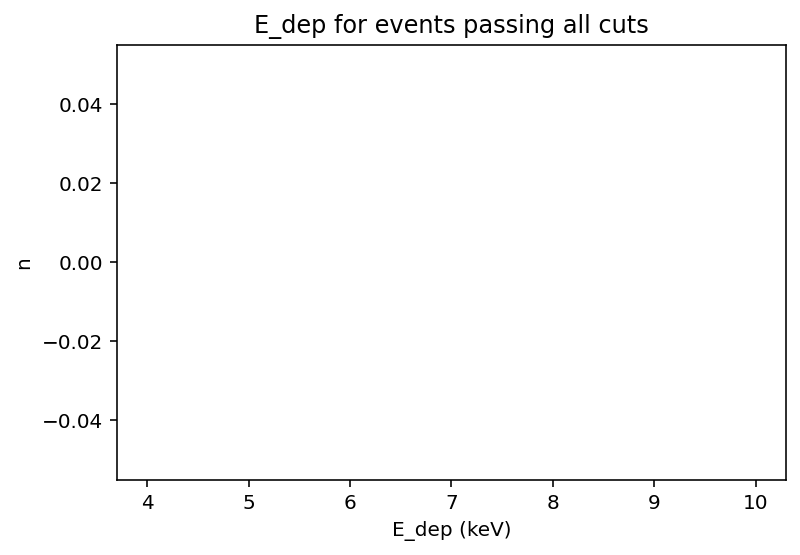

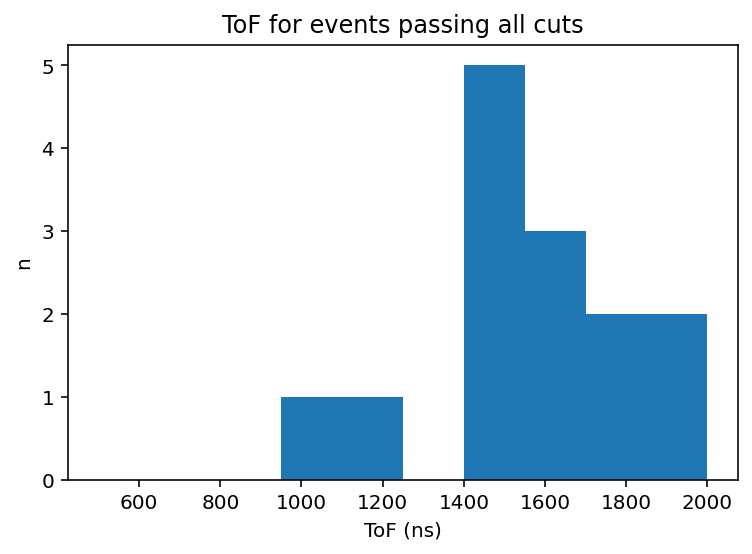

32


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 576x576 with 2 Axes>

In [38]:
plt.hist(E_dep_list_final, range=(4,10))
plt.title("E_dep for events passing all cuts")
plt.xlabel("E_dep (keV)")
plt.ylabel("n")
plt.show()

plt.hist(candidate_pulse_time_diff_final, range=(500,2000))
plt.title("ToF for events passing all cuts")
plt.xlabel("ToF (ns)")
plt.ylabel("n")
plt.show()

print(len(E_dep_list_final))
#print(good_event_ids[0:2])

#print(E_dep_list_final[0:10])
#print(ToF_list_final[0:10])

energy_hist = bh.Histogram(bh.axis.Regular(100, 0, 400),bh.axis.Regular(100, 0, 20))
energy_hist.fill(ToF_list_final, E_dep_list_final)
fig = plt.figure(figsize=(8, 8))
plt.xlabel('KE (keV)')
plt.ylabel('E_dep (keVnr)')
plt.title('Run 10797-10891, LZap-5.4.9, [500,1000]ns coin window') 
mplhep.hist2dplot(energy_hist, norm=LogNorm())

signal_hist = bh.Histogram(bh.axis.Regular(100, 0, 20),bh.axis.Regular(100, 1, 5))
signal_hist.fill(s1_list_final, logs2_list_final)
fig = plt.figure(figsize=(8, 8))
plt.xlabel('S1 (phd)')
plt.ylabel('logS2 (phd)')
plt.title('Run 10797-10891, LZap-5.4.9, [500,1000]ns coin window, [5000, 6500]mVns Href pulse') 
mplhep.hist2dplot(signal_hist, norm=LogNorm())

position_hist = bh.Histogram(bh.axis.Regular(100, -80, 80),bh.axis.Regular(100, -80, 80))
position_hist.fill(xpos_list_final, ypos_list_final)
fig = plt.figure(figsize=(8, 8))
plt.xlabel('xpos (cm)')
plt.ylabel('ypos (cm)')
plt.title('Run 10797-10781, LZap-5.4.9, [500,1000]ns coin window') 
mplhep.hist2dplot(position_hist, norm=LogNorm())

#plt.hist2d(ToF_list_final, E_dep_list_final, range = ([0,250],[0,15]), bins=(50, 50), cmap=plt.cm.jet)
#plt.show()
print(ToF_list_final)
print(E_dep_list_final)

print("Total events passing s1 and s2 cut sizes: ", s1_s2_cut_pass)
print("Total events passing all non-pulse cuts: ", all_cut_pass)
print("Total events passing all cuts: ", len(ToF_list_final))
print("Total events: ", total)

In [127]:
print(num_candidate_pulses)

[383.   7.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]


In [18]:
file = uproot.open(dd_files[1])
peakTime = file['External']['pmtDDReflector./pmtDDReflector.peakTime_ns'].array(library='np')
pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
pulseEndTime = file['External']['pmtDDReflector./pmtDDReflector.pulseEndTime_ns'].array(library='np')
limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')
s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
s2_pulse_id = file['Scatters']['ss./ss.s2PulseID'].array(library='np')

s1_area = file['Scatters']['ss./ss.s1Area_phd'].array(library='np')
s2_area = file['Scatters']['ss./ss.s2Area_phd'].array(library='np')
ss_number = file['Scatters']['ss./ss.nSingleScatters'].array(library='np')

pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')
pulseAreaTPC = file['Events']['pulsesTPC./pulsesTPC.pulseArea_phd'].array(library='np')

s1_start_times = []
s2_start_times = []
s1Area = []
s2Area = []

xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
rpos = np.sqrt(xpos**2 + ypos**2)
drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000

rpos_cut = (rpos < rpos_lim)
y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])
#Find S1,S2 start times and areas for each recorded event

for j in range(len(s1_pulse_id)):
    s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]])
    s1Area.append(pulseAreaTPC[j][s1_pulse_id[j]])
    s2_start_times.append(pulseStartTimeTPC[j][s2_pulse_id[j]])
    s2Area.append(pulseAreaTPC[j][s2_pulse_id[j]])

s1_start_times = np.array(s1_start_times)
s2_start_times = np.array(s2_start_times)
s1Area = np.array(s1Area)
s2Area = np.array(s2Area)


#s1 and s2 area cuts
s1_area_cut = (s1Area > 4) & (s1Area < 20)
s2_area_cut = (np.log10(s2Area) > 2.5) & (np.log10(s2Area) < 3.5)

ss_cut = (ss_number > 0)
#candidate_s1_cut = (evt_arrays['pulsesTPC.s1Probability']==1) | (evt_arrays['pulsesTPC.otherProbability']==1)
#s1_s2_basic_timing_cut = (s2_start_times - s1_start_times > 0)

s1Area_cuts = s1Area[s1_area_cut&s2_area_cut&ss_cut]
s2Area_cuts = s2Area[s1_area_cut&s2_area_cut&ss_cut]
print(s1Area_cuts[0:10])
print(s2Area_cuts[0:10])
#s1_s2_cut_pass += len(xpos[s1_area_cut&s2_area_cut])
#s1_s2_ss_cut_pass += len(xpos[s1_area_cut&s2_area_cut&ss_cut])
#all_cut_pass += len(xpos[s1_area_cut&s2_area_cut&ss_cut&rpos_cut&y_cut&z_cut&s1_s2_basic_timing_cut])
#total += len(xpos)

#Calculate energy deposited into LXe
E_dep_cuts = (((s1Area_cuts/g1)+(s2Area_cuts/g2))/11)**(1/1.1)
print(E_dep_cuts[0:10])
#Warning: this is only an estimate of energy deposited! Need to incorporate uncertainty as well


[ 8.138428  11.011719   5.469591   5.8178663  7.3711004  7.2886963]
[ 443.97705  422.57715  530.9016  2028.9429  1188.1602   687.20337]
[6.2781773 8.059248  4.6586595 6.6728134 6.6680555 6.0240617]


/tmp/ipykernel_44979/1903328530.py:46: RuntimeWarning: divide by zero encountered in log10
  s2_area_cut = (np.log10(s2Area) > 2.5) & (np.log10(s2Area) < 3.5)


In [7]:
xy_hist = bh.Histogram(bh.axis.Regular(200, -80, 80),bh.axis.Regular(200, -80, 80))
area_hist = bh.Histogram(bh.axis.Regular(100,0,0.4), bh.axis.Regular(100,0,10000))

rpos_lim = 67.8
drift_time_lim = [10,90]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 40
b_lb = -80
coin_window_ns = 2000


#Numpy arrays works fine for event level RQs but awkward needed for pulse level

for i in range(len(dd_files)):
    if (i == 0):
        continue
    file = uproot.open(dd_files[i])
    ss_cut = (file['Scatters;1']['ss./ss.nSingleScatters']==1)
    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    #print(len(xpos))
    #print(len(file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')))
    #print(len(href_signal_cut))

    rpos = np.sqrt(xpos**2 + ypos**2)
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000

    rpos_cut = (rpos < rpos_lim)
    y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])

    #href_signal_cut = href_signal_cut[0:1000]
    #print(len(href_signal_cut))
    #xpos = xpos[rpos_cut&z_cut&href_signal_cut]
    #ypos = ypos[rpos_cut&z_cut&href_signal_cut]
    xpos = xpos[rpos_cut&z_cut]
    ypos = ypos[rpos_cut&z_cut]
    #xpos = xpos[z_cut]
    #ypos = ypos[z_cut]
    
    xy_hist.fill(xpos,ypos)
    for j in range(len(dd_files[i])):
        tail_area = file['External']['pmtDDReflector./pmtDDReflector.tailArea_mVns'].array(library='np')[j]
        prompt_area = file['External']['pmtDDReflector./pmtDDReflector.promptArea_mVns'].array(library='np')[j]
        limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')[j]
        tail_prompt = tail_area/(tail_area + prompt_area)
        area_hist.fill(tail_prompt,limited_area)
        
    #print(xpos)
    #print(ypos)


/tmp/ipykernel_36130/3468700060.py:27: RuntimeWarning: overflow encountered in square
  rpos = np.sqrt(xpos**2 + ypos**2)
/tmp/ipykernel_36130/3468700060.py:48: RuntimeWarning: divide by zero encountered in true_divide
  tail_prompt = tail_area/(tail_area + prompt_area)


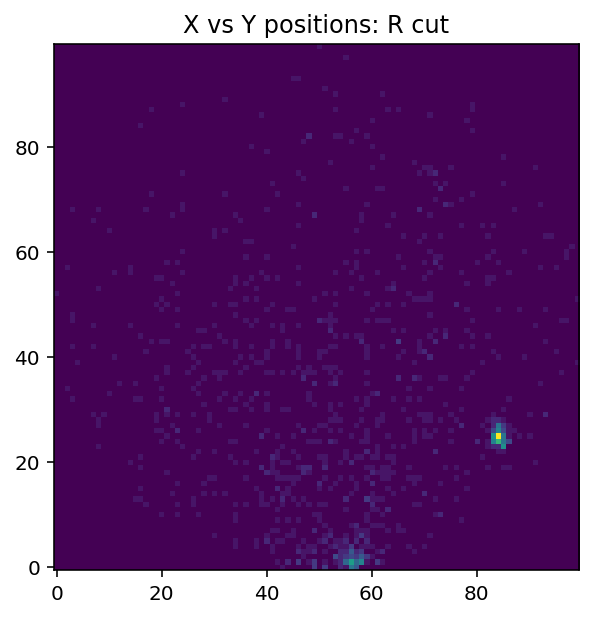

In [49]:
fig = plt.figure(figsize=(8, 8))
plt.xlabel('tail/(tail+prompt)')
plt.ylabel('limitedArea (mVns)')
plt.title('Pre-SR2 Href, LZap-5.4.9') 
mplhep.hist2dplot(area_hist, norm=LogNorm())

In [ ]:
xy_hist = bh.Histogram(bh.axis.Regular(200, -80, 80),bh.axis.Regular(200, -80, 80))
area_hist = bh.Histogram(bh.axis.Regular(100,0,0.4), bh.axis.Regular(100,0,10000))

rpos_lim = 67.8
drift_time_lim = [10,90]
#Need to change these parameters to get realistic conduit profile
m_ub = 0
m_lb = 0
b_ub = 40
b_lb = -80
coin_window_ns = 2000


#Numpy arrays works fine for event level RQs but awkward needed for pulse level

for i in range(len(dd_files)):
    if (i == 0):
        continue
    file = uproot.open(dd_files[i])
    ss_cut = (file['Scatters;1']['ss./ss.nSingleScatters']==1)
    xpos = file['Scatters;1']['ss./ss.x_cm'].array(library='np')
    ypos = file['Scatters;1']['ss./ss.y_cm'].array(library='np')
    
    #print(len(xpos))
    #print(len(file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')))
    #print(len(href_signal_cut))

    rpos = np.sqrt(xpos**2 + ypos**2)
    drift_time_us = file['Scatters;1']['ss./ss.driftTime_ns'].array(library='np')/1000

    rpos_cut = (rpos < rpos_lim)
    y_cut = (ypos < (m_ub*xpos+b_ub)) & (ypos > (m_lb*xpos+b_lb))
    z_cut =  (drift_time_us>drift_time_lim[0]) & (drift_time_us<drift_time_lim[1])

    #href_signal_cut = href_signal_cut[0:1000]
    #print(len(href_signal_cut))
    #xpos = xpos[rpos_cut&z_cut&href_signal_cut]
    #ypos = ypos[rpos_cut&z_cut&href_signal_cut]
    xpos = xpos[rpos_cut&z_cut]
    ypos = ypos[rpos_cut&z_cut]
    #xpos = xpos[z_cut]
    #ypos = ypos[z_cut]
    
    xy_hist.fill(xpos,ypos)
    for j in range(len(dd_files[i])):
        tail_area = file['External']['pmtDDReflector./pmtDDReflector.tailArea_mVns'].array(library='np')[j]
        prompt_area = file['External']['pmtDDReflector./pmtDDReflector.promptArea_mVns'].array(library='np')[j]
        limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')[j]
        tail_prompt = tail_area/(tail_area + prompt_area)
        area_hist.fill(tail_prompt,limited_area)
        
    #print(xpos)
    #print(ypos)


In [142]:
#Testing for individual event analysis

d = 1128

file = uproot.open(dd_files[1])
peakTime = file['External']['pmtDDReflector./pmtDDReflector.peakTime_ns'].array(library='np')
pulseAreaExt = file['External']['pmtDDReflector./pmtDDReflector.pulseArea_mVns'].array(library='np')
pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
pulseEndTime = file['External']['pmtDDReflector./pmtDDReflector.pulseEndTime_ns'].array(library='np')
limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')
s1_pulse_id = file['Scatters']['ss./ss.s1PulseID'].array(library='np')
s2_pulse_id = file['Scatters']['ss./ss.s2PulseID'].array(library='np')

s1_area = file['Scatters']['ss./ss.s1Area_phd'].array(library='np')
s2_area = file['Scatters']['ss./ss.s2Area_phd'].array(library='np')
s1_corrected_area = file['Scatters']['ss./ss.correctedS1Area_phd'].array(library='np')
s2_corrected_area = file['Scatters']['ss./ss.correctedS2Area_phd'].array(library='np')
ss_number = file['Scatters']['ss./ss.nSingleScatters'].array(library='np')

pulseStartTimeTPC = file['Events']['pulsesTPC./pulsesTPC.pulseStartTime_ns'].array(library='np')
pulseAreaTPC = file['Events']['pulsesTPC./pulsesTPC.pulseArea_phd'].array(library='np')

s1_start_times = []
s2_start_times = []

for j in range(len(s1_pulse_id)):
    s1_start_times.append(pulseStartTimeTPC[j][s1_pulse_id[j]])
    #s1Area.append(pulseAreaTPC[j][s1_pulse_id[j]])
    s2_start_times.append(pulseStartTimeTPC[j][s2_pulse_id[j]])
    #s2Area.append(pulseAreaTPC[j][s2_pulse_id[j]])

s1_start_times = np.array(s1_start_times)
s2_start_times = np.array(s2_start_times)
s1_area = pulseAreaTPC[d][s1_pulse_id[d]]
s2_area = pulseAreaTPC[d][s2_pulse_id[d]]
print("S1 Pulse Area: ", pulseAreaTPC[d][s1_pulse_id[d]])
print("S2 Pulse Area: ", pulseAreaTPC[d][s2_pulse_id[d]])
print("S1 Start Time: ", pulseStartTimeTPC[d][s1_pulse_id[d]])
print("S2 Start Time: ", pulseStartTimeTPC[d][s2_pulse_id[d]])
time_difference = pulseStartTimeTPC[d][s2_pulse_id[d]] - pulseStartTimeTPC[d][s1_pulse_id[d]]
print("Drift time: ", time_difference)
print("Drift time (us): ", time_difference/1000.)
E_dep = (((s1_area/g1)+(s2_area/g2))/11)**(1/1.1)
print("Energy Deposited: ",E_dep)

#Check for coincidence Href pulse
#print(pulseStartTime[3])
#print(pulseAreaExt[3])
start_time_cut = (pulseStartTimeTPC[d][s1_pulse_id[d]] - pulseStartTime[d] < 5000) & (pulseStartTimeTPC[d][s1_pulse_id[d]] - pulseStartTime[d] > 0)
print(pulseAreaExt[d][start_time_cut])
print(pulseStartTimeTPC[d][s1_pulse_id[d]] - pulseStartTime[d][start_time_cut])

S1 Pulse Area:  5.984375
S2 Pulse Area:  178.59576
S1 Start Time:  2270
S2 Start Time:  48700
Drift time:  46430
Drift time (us):  46.43
Energy Deposited:  4.567238520883219
[6735.2266]
[1310]


In [63]:
#Finding >4000 mVns trigger rate of H-ref
file = uproot.open(dd_files[1])
pulseStartTime = file['External']['pmtDDReflector./pmtDDReflector.pulseStartTime_ns'].array(library='np')
limited_area = file['External']['pmtDDReflector./pmtDDReflector.limitedArea_mVns'].array(library='np')
trigger_rate = []

for i in range(len(limited_area)):
    pulse_size_cut = (limited_area[i] > 4000)
    trigger_rate.append((pulseStartTime[i][-1] - pulseStartTime[i][0])/len(limited_area[i][pulse_size_cut]))

In [64]:
print(trigger_rate[0:100])

[8877.688442211056, 7328.982300884956, 8350.888888888889, 8055.748792270531, 9889.738562091503, 7720.619469026548, 9288.115183246073, 8649.828571428572, 8277.407407407407, 7529.009433962264, 7827.342995169082, 9060.15306122449, 8897.386934673366, 10224.607329842933, 8000.783410138249, 8418.71921182266, 9365.406698564593, 7819.049773755656, 8562.407407407407, 7707.938596491228, 8302.433628318584, 9509.137055837564, 8426.292682926829, 8400.188679245282, 8840.5, 8902.970297029702, 8880.265957446809, 7864.713656387666, 7608.363636363636, 8968.155339805826, 7955.183486238532, 8891.232876712329, 8848.695652173914, 7300.5907172995785, 10146.702702702703, 7684.5739910313905, 8250.143540669857, 9209.0625, 9670.10152284264, 7924.4843049327355, 9113.578431372549, 8412.12669683258, 10074.15300546448, 7670.148514851485, 8162.512315270936, 9095.075376884422, 8581.014492753624, 7956.8493150684935, 8113.733333333334, 9559.073170731708, 7786.666666666667, 8307.05069124424, 8699.678899082568, 8341.32075

In [ ]:
def getFilePaths_oneEvt(runId:int, evtId:int, lzap:str, conditions:str=None):
    DATA_DC = 'usdc'
    #setup catalog
    CATALOG_APPLICATION = "https://lz-catalog.lbl.gov/catalog/{}/report/".format(DATA_DC)
    CATALOG_DEBUG = 0
    cat = Catalog(CATALOG_APPLICATION, 'url',  xml=('1'==CATALOG_DEBUG), triggers = ['canonical_path'])

    #create request: raw files for this project
    sel = cat.select('run',runId) \
             .select('first_event_id', slice(0, evtId+1)).select('last_event_id', slice(evtId,999999999)) \
             .select('type', 'raw')
    if len(sel) ==0:
      # if file path is not found because 'first_event_id' is not found in DataCatalog
      rawPath0 = list(cat.select('run',runId).select('sequence',0).select('type', 'raw'))[0]
      with uproot.open(rawPath0) as f:
        nEvtsFile = f['Summary']['nEvtsFile'].array()[0] # number of events per raw file
      rawPath = list(cat.select('run',runId).select('sequence',int(evtId/nEvtsFile)).select('type', 'raw'))[0]
    else:
      # if file path is found
      rawPath = list(sel)[0]

    sel = cat.select('run',runId) \
             .select('first_event_id', slice(0, evtId+1)).select('last_event_id', slice(evtId,999999999)) \
             .select('type', 'rq') \
             .select('software_versions',lzap) \
             .select('conditions_version',conditions)
    rqPath = list(sel)[0]    

    return rawPath, rqPath